In [1]:
# Importing necessary packages for all sections of the lab 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from astropy.modeling import models, fitting
from scipy import stats, optimize
from scipy.signal import find_peaks
from numpy.polynomial import Polynomial
import astroalign as aa
from IPython.display import display, Image
zscale = ZScaleInterval()

<span style="font-size: 30px; font-weight: bold;">AST 443 - Lab 1: Properties of CCD Cameras</span>  <br>
<span style="font-size: large;">Author List/SBU ID's: 115070985, 114918484</span>  <br>
<span style="font-size: 18px;">Observation Date: September 4th, 2024</span>  <br>
<span style="font-size: 18px;">Report Date: October 3rd, 2024</span>

## Purpose 

The primary objective of this lab is to gain practical experience with various astronomical instruments and to develop an understanding of their operation, preparing us for future observations throughout the semester. The major equipment utilized includes the 14-inch Meade LX200-ACF telescope atop of Mt. Stony Brook, the STL1001 CCD Camera, the ST402ME CCD Camera, the DADOS Spectrograph, and CCDSoft for software data acquisition. In the imaging section, we collected data to assess the performance of the CCD cameras, focusing on characterizing the cameras' response through bias frames, dark frames, dark current, and flat field measurements. For the spectrograph section, we obtained spectral data from a neon arc lamp, which will aid in establishing calibration strategies and understanding the dispersion characteristics of the DADOS Spectrograph. This comprehensive data collection serves to enhance our understanding of the equipment's performance and prepares us for subsequent observational tasks.



## Section 4.1: Bias Frames
A **bias frame** is an image captured with zero exposure duration zero light exposure (shutter closed), used to measure the baseline electronic noise of the CCD camera. This frame records the inherent offsets and noise characteristics of every pixel. By subtracting the bias frame from the corresponding light frames, we can eliminate systematic errors caused by the camera's electronics.

##### Section 4.1.1:
To start off this section of the lab analysis, we open the bias frame that was observed at an intended temperature of $0^\circ \text{C}$ through the standard `astropy.fits` package. The actual temperature noted in the header of the FITS file is $-0.2318^\circ \text{C}$. This value is in agreement with the intended temperature since it falls within the acceptable range of $\pm 1^\circ \text{C}$ of our expected parameter.

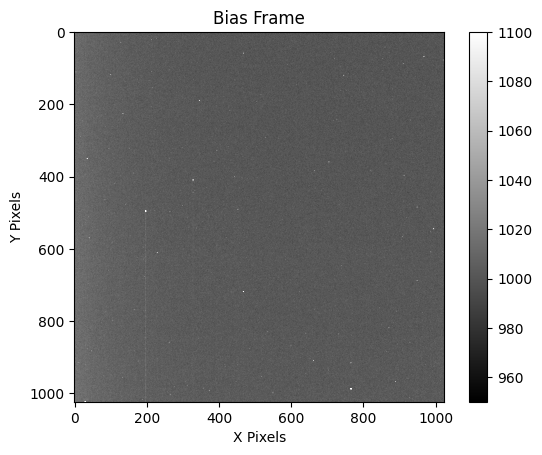

In [2]:
def open_and_plot_bias_frame(file_path):
    """
    Open a FITS bias frame file and plot its data with a colorbar.
    
    :param file_path: Path to the FITS file containing the bias frame data.
    :type file_path: str
    :return: 2D array of pixel intensity values from the bias frame.
    :rtype: np.ndarray
    """
    # Opening the FITS file
    bias_frame = fits.open(file_path)
    # Loading data from FITS file
    bias_frame_data = bias_frame[0].data
    # Plotting the data with a colorbar
    plt.imshow(bias_frame_data, cmap='gray', vmin=950, vmax=1100)
    plt.colorbar()
    plt.xlabel('X Pixels')
    plt.ylabel('Y Pixels')
    plt.title('Bias Frame')
    plt.show()

    return bias_frame_data

# Call the function 
bias_frame_data = open_and_plot_bias_frame(r"../FITS_Files/3.1_bias.00000011.BIAS.FIT")

We then plot a histogram of the pixel intensity distribution. The histogram is constructed by flattening the 2D bias frame data into a 1D array. We optimize the plot parameters, including the range of pixel intensities and the number of bins, to clearly visualize the distribution of counts. Note that we apply a logarithmic scale to better visualize the histogram. 

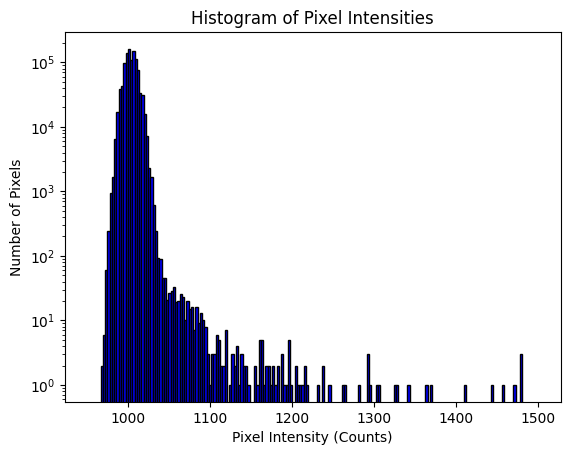

In [3]:
def plot_bias_histogram(bias_frame_data):
    """
    Plot a histogram of the pixel intensity distribution from the bias frame data.
    
    :param bias_frame_data: 2D array of pixel intensity values from the bias frame.
    :type bias_frame_data: np.ndarray
    :return: Flattened data of pixel intensities.
    :rtype: np.ndarray
    """
    # Flattening the data into a 1D array
    flattened_data = bias_frame_data.flatten()
    # Plotting the histogram of intensity values
    plt.hist(flattened_data, bins=200, range=(950, 1500), log=True, color='blue', edgecolor='black')  
    plt.title('Histogram of Pixel Intensities')
    plt.xlabel('Pixel Intensity (Counts)')
    plt.ylabel('Number of Pixels')
    plt.show()
    
    return flattened_data

# Call the function
flattened_data = plot_bias_histogram(bias_frame_data)

The histogram above clearly shows the presence of saturated pixels, known as "hot pixels." These pixels exhibit significantly higher dark currents, deviating from the expected Gaussian distribution of pixel intensities. To address this issue, the following code filters out pixel intensity values greater than $1050$ counts. 

By removing the hot pixels, we can better visualize the typical distribution of pixel intensities in the filtered data. Although the task does say to identify these hot pixels, displaying all 413 results would be cumbersome, so they are not shown here. This was done in the function below, where the plotting methodology is roughly the same as in the previous function. 

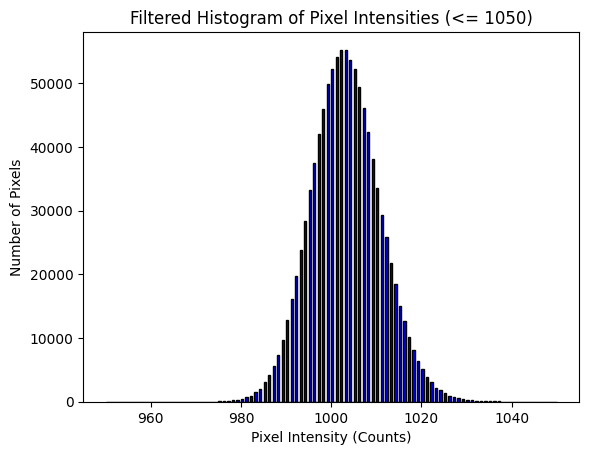

In [4]:
def filter_and_plot_histogram(flattened_data, threshold=1050):
    """
    Filter the pixel intensity data, and plot a histogram of the filtered data.

    :param flattened_data: 1D array of pixel intensity values from the bias frame.
    :type flattened_data: np.ndarray
    :param threshold: Intensity threshold to filter the pixel values.
    :type threshold: int
    :return: Filtered data (1D array), Hot pixels (list of lists with [index, value]), Number of rejected pixels.
    :rtype: tuple(np.ndarray, list, int)
    """
    # Filtering the data to include only values less than or equal to the threshold
    filtered_data = flattened_data[flattened_data <= threshold]
    # Plotting the filtered histogram
    plt.hist(filtered_data, bins=200, range=(950, 1050), color='blue', edgecolor='black')
    plt.title('Filtered Histogram of Pixel Intensities (<= 1050)')
    plt.xlabel('Pixel Intensity (Counts)')
    plt.ylabel('Number of Pixels')
    plt.show()

    return filtered_data

# Call the function
filtered_data = filter_and_plot_histogram(flattened_data)

We see that the histogram of filtered data provides a expected Gaussian distribution of points, with their being no errenous pixel intensities. The function below calculates the number of pixels that were filtered out due to exceeding the specified intensity threshold. This was done by taking the difference between the pixels in the flattened data and the filtered data. 

In [5]:
def calculate_pixel_statistics(flattened_data, filtered_data):
    """
    Calculate and print the number and fraction of pixels cut due to exceeding the intensity threshold.
    
    :param flattened_data: 1D array of pixel intensity values from the bias frame.
    :type flattened_data: np.ndarray
    :param filtered_data: 1D array of pixel intensity values that are below or equal to the threshold.
    :type filtered_data: np.ndarray
    :return: None
    :rtype: None
    """
    # Calculate the number of pixels cut
    num_cut_pixels = len(flattened_data) - len(filtered_data)
    # Calculate the fraction of pixels that were cut
    fraction_cut = (num_cut_pixels / len(flattened_data)) * 100
    # Output the statistics
    print(f"Number of pixels cut: {num_cut_pixels}")
    print(f"Fraction of pixels cut: {fraction_cut:.4f}%")

# Call the function 
calculate_pixel_statistics(flattened_data, filtered_data)

Number of pixels cut: 413
Fraction of pixels cut: 0.0394%


The results of the pixel filtering process indicate that a total of $413$ pixels were cut from the dataset due to exceeding the specified intensity threshold. This number aligns with our previous analysis, whether we consider the count of hot pixels or determine the difference between the original and filtered data. Notably, this corresponds to a precent difference of $0.04%$ of the total pixel count in the bias frame. These statistics highlight the minimal impact of pixel saturation on the overall pixel distribution, suggesting that the majority of pixels conform to the expected Gaussian distribution. 

##### Section 4.1.2:
We begin this subsection with calculating the mean and standard deviation of the filtered pixel intensity data from the bias frame. This is simply done by running through Numpy's built in functions. From here, this data is used to determine the read noise of the CCD in units of counts. 


In [6]:
def calculate_mean_std(filtered_data):
    """
    Calculate the mean and standard deviation of filtered pixel intensity data.
    
    :param filtered_data: 1D array of filtered pixel intensity values.
    :type filtered_data: np.ndarray
    :return: Mean and standard deviation of the filtered data.
    :rtype: tuple(float, float)
    """
    # Calculate the mean and standard deviation of the filtered data
    mean_filtered = np.mean(filtered_data)
    std_filtered = np.std(filtered_data)
    # Output the statistics
    print(f"Mean of filtered data: {mean_filtered:.4f}")
    print(f"Standard deviation of filtered data: {std_filtered:.4f}")
    
    return mean_filtered, std_filtered

# Call the function
mean_filtered, std_filtered = calculate_mean_std(filtered_data)

Mean of filtered data: 1002.9957
Standard deviation of filtered data: 7.7180


The mean of the filtered data is 1003 counts, accompanied by a standard deviation of 7.72 counts. These calculations were performed within a range defined by the previosuly defined threshold, which has a maximum value set at **1050** counts.

Now, we plot a histogram of the filtered pixel intensities from the bias frame, along with an overlaid Gaussian fit. The function uses fitting methods from the `astropy.modeling` package, particularly `Gaussian1D` and `LevMarLSQFitter`, to produce the desired fit. The choice of using 100 bins instead of 200 is deliberate to ensure that the Gaussian curve maintains a higher amplitude when compared to the histogram. When using a larger number of bins, the histogram can become overly fragmented, leading to lower counts in each bin. This fragmentation results in a less pronounced peak for the Gaussian fit, making it more challenging to observe the underlying distribution of the data. 


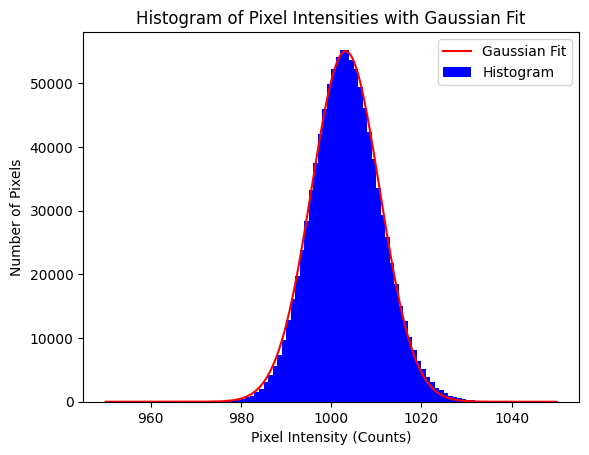

In [7]:
def plot_gaussian(data, range_values, mean, stddev, num_bins):
    """
    Plot a histogram of the pixel intensities with an overlaid Gaussian fit.
    
    :param data: The pixel intensity data to plot.
    :type data: np.ndarray
    :param range_values: The range for the histogram (min, max).
    :type range_values: tuple(float, float)
    :param mean: The mean of the Gaussian fit.
    :type mean: float :unit: Analog Digital Unit (ADU)
    :param stddev: The standard deviation of the Gaussian fit.
    :type stddev: float :unit: Analog Digital Unit (ADU)
    :param num_bins: The number of bins to use for the histogram.
    :type num_bins: int
    :return: Displays the plot with the histogram and Gaussian fit.
    :rtype: None
    """
    # Calculate histogram
    bin_heights, bin_borders = np.histogram(data, bins=num_bins, range=range_values)
    bin_widths = np.diff(bin_borders)
    bin_centers = bin_borders[:-1] + bin_widths / 2
    # Initialize Gaussian model
    gaussian = models.Gaussian1D(mean=mean, stddev=stddev)
    # Select fitting algorithm
    fitter = fitting.LevMarLSQFitter()
    # Fit the Gaussian model to the histogram data
    best_fit = fitter(gaussian, bin_centers, bin_heights)
    # Determine x-values for Gaussian fit
    x_interval_gaussian = np.linspace(range_values[0], range_values[1], 10000)
    # Plot the histogram and the Gaussian fit
    plt.figure()
    plt.bar(bin_centers, bin_heights, width=bin_widths, label='Histogram', log=False, color='blue')
    plt.plot(x_interval_gaussian, best_fit(x_interval_gaussian), label='Gaussian Fit', color='red')
    plt.xlabel('Pixel Intensity (Counts)')
    plt.ylabel('Number of Pixels')  
    plt.title('Histogram of Pixel Intensities with Gaussian Fit')
    plt.legend()
    plt.show()

# Call the function 
plot_gaussian(data=filtered_data, range_values=(950, 1050), mean=mean_filtered, stddev=std_filtered, num_bins=100)

Now the function below takes a 1D array of filtered pixel intensity values from the bias frame as input, and calcualtes the number of electrons based on the standard deviation of filtered pixel intensity values from the bias frame. It then calculates the difference between this measured value and the actual number of electrons, defined as the root mean square (RMS) for the camera. All formulas are fairly simple and can be seen directly in the code. 

In [8]:
def calculate_measured_electrons(filtered_data, gain=2, actual_num_electrons=14.8):
    """
    Calculate the measured number of electrons based on the gain of the camera and 
    the standard deviation of the filtered pixel data. This function also computes 
    the difference and percentage error between the measured and actual number of 
    electrons.

    :param filtered_data: 1D array of filtered pixel intensity values from the bias frame.
    :type filtered_data: np.ndarray
    :param gain: The gain of the camera in electrons per Analog Digital Unit (ADU).
    :type gain: float
    :param actual_num_electrons: The actual number of electrons (RMS) for the camera.
    :type actual_num_electrons: float
    :return: A tuple containing the measured number of electrons and the percentage error.
    :rtype: tuple(float, float)
    """
    # Calculate the measured number of electrons
    measured_num_electrons = gain * np.std(filtered_data)
    # Calculate the difference and percentage error
    difference = measured_num_electrons - actual_num_electrons
    percentage_error = (difference / actual_num_electrons) * 100
    # Output the statistics formatted to two decimal places
    print(f"Measured Number of Electrons: {measured_num_electrons:.4f} e-")
    print(f"Percentage Error: {percentage_error:.4f}%")

    return measured_num_electrons, percentage_error

# Call the function 
measured_electrons, percent_error = calculate_measured_electrons(filtered_data)

Measured Number of Electrons: 15.4360 e-
Percentage Error: 4.2976%


In this cell above, we calculate the measured number of electrons based on the gain of the camera and the standard deviation of the filtered pixel data. The gain refers to the proportionality factor that relates the number of electrons generated by incident light (photons) to the corresponding digital output value. If we assume that one incident light excites one electrons, then the gain can be mathematically expressed as:
$$
\text{Gain} = \frac{N_{electrons}}{N_{counts}}
$$
According to the spec sheet for the STL1001 CCD Camera, the actual gain is 2 $e^{-}$/ADU (electrons per Analog Digital Unit) and the actual number of electrons is 14.8 e- RMS (electrons root mean square). With a read noise equal to the standard deviation of the counts of the filtered data, which was previously determined to be 7.72, the number fo electrons were found to be:
$$
\text{Number of electrons} = 2 * 7.72 = 15.44 e^{-}
$$
 Since the percentage error between the measured and actual number of electrons is less than 5% (4.3% to be specific), we can conclude that our measurement aligns well with the expected values specified in the STL1001 CCD Camera's specifications. Therefore, our result is consistent with the manufacturer's description.

 





## Section 4.2: Dark Frames 
A **dark frame** is an image captured with the camera's shutter closed, taken at the same exposure time as the light frames being taken. Dark frames are crucial in the image processing pipeline, as they help to identify and remove unwanted noise generated by the camera sensor (dark current being the most prominant) and other electronic components. By subtracting dark frames from the corresponding light frames, astronomers can improve the quality of their images and data. 

##### Section 4.2.1:

We begin this section by creating a **master dark frame** by median-combining a series of 10 dark frames with the same exposure time. The function reads each dark frame from the specified file template, stacks them from a 2D array into a 3D array, and then calculates the median across this stack to produce a single two-dimensional master dark frame.

In [9]:
def create_master_dark(file_template, num_frames):
    """
    Create a master dark frame by median-combining dark frames.
    
    :param file_template: Template path for the dark frame files with placeholders for the frame number.
    :type file_template: str
    :param num_frames: The number of dark frames to combine.
    :type num_frames: int
    :return: Master dark frame (2D np.ndarray), Stack of individual dark frames (3D np.ndarray)
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # List to store the data from each dark frame
    dark_frames_data = []
    # Loop through each dark frame and read the data
    for i in range(num_frames):
        # Construct the file name based on the frame number
        file_path = file_template.format(i)
        # Open the FITS file and extract the data
        with fits.open(file_path) as hdul:
            dark_frames_data.append(hdul[0].data)
    # Stack the frames into a 3D array (stack of 2D frames)
    stacked_frames = np.stack(dark_frames_data, axis=0)
    # Calculate the median across the stack (axis=0)
    master_dark_frame = np.median(stacked_frames, axis=0)
    
    return master_dark_frame, stacked_frames

# Template for the file names (with placeholder)
file_template = r"..\FITS_Files\3.2.3_10_dark_frames_30_sec.{:08d}.DARK.FIT"
# Number of dark frames to combine
num_frames = 10
# Call the function
master_dark_frame, dark_frames = create_master_dark(file_template, num_frames)

We apply the same methodology to output the histogram of pixel intensities for the median dark frame. First, the median of the master dark frame is computed, which serves as a central value for pixel intensity distribution. Next, the data is flattened into a 1D array. The function filters this data to include only pixel intensities less than or equal to a threshold value, allowing us to focus on the bulk of the pixel intensity distribution. Here we chose the same value as from Section 4.1 (that being **1050** counts). From here two histograms are plotted with the exact definition or purpose compared to the previous section.

Median value of the master dark frame: 1022.0


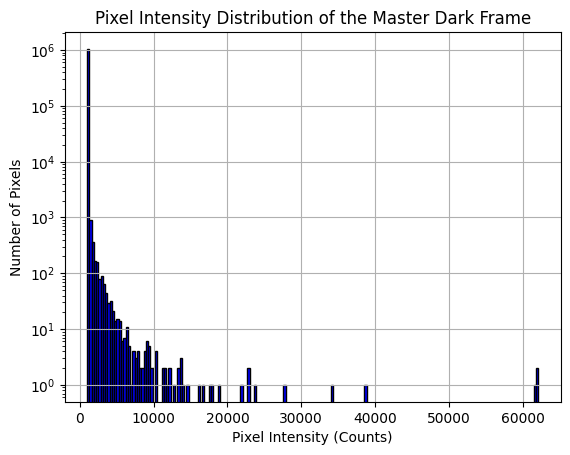

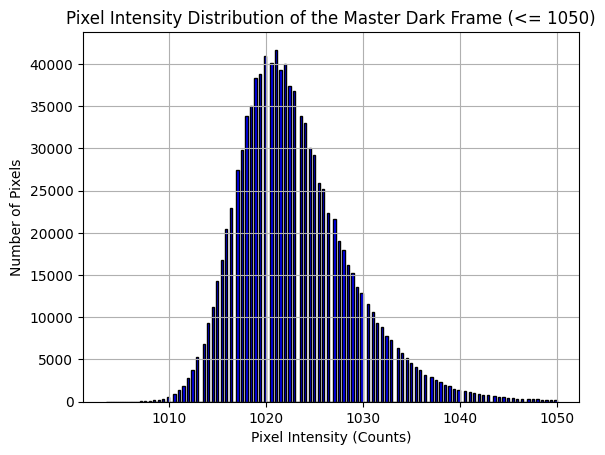

In [10]:
def analyze_master_dark(master_dark_frame, threshold=1050):
    """
    Analyze the master dark frame by calculating the median value and plotting histograms.
    
    :param master_dark_frame: The master dark frame to analyze.
    :type master_dark_frame: np.ndarray
    :param threshold: Intensity threshold to filter pixel values.
    :type threshold: int
    :return: Median value of the master dark frame, filtered pixel data (1D np.ndarray)
    :rtype: tuple(float, np.ndarray)
    """
    # Calculate the median value of the master dark frame
    median_value = np.median(master_dark_frame)
    # Output the median value
    print(f"Median value of the master dark frame: {median_value:2}")
    # Flattening the data into a 1D array
    flattened_data = master_dark_frame.flatten()
    # Filtering the data to include only values less than or equal to the median
    filtered_data = flattened_data[flattened_data <= threshold]
    # Plot the histogram of pixel intensities for the entire master dark frame
    plt.figure()
    plt.hist(flattened_data, range=(np.min(flattened_data), np.max(flattened_data)), bins=200, log=True, color='blue', edgecolor='black')
    plt.title('Pixel Intensity Distribution of the Master Dark Frame')
    plt.xlabel('Pixel Intensity (Counts)')
    plt.ylabel('Number of Pixels')
    plt.grid(True)
    # Plot the histogram of filtered pixel intensities
    plt.figure()
    plt.hist(filtered_data, range=(np.min(filtered_data), np.max(filtered_data)), bins=200, color='blue', edgecolor='black')
    plt.title('Pixel Intensity Distribution of the Master Dark Frame (<= 1050)')
    plt.xlabel('Pixel Intensity (Counts)')
    plt.ylabel('Number of Pixels')
    plt.grid(True)
    
    return median_value, filtered_data

# Call the function 
median_value, filtered_data = analyze_master_dark(master_dark_frame)

In our analysis of the data, we initially observe that the Gaussian distribution appears concentrated within a limited range. We designate the pixel value of 10,000 as the point where this correlation starts to weaken, suggesting that pixels with values above this threshold can be classified as warm. This threshold is justified by the noticeable change in the trend of the data, marking a transition where the relationship between the pixel values begins to diminish. To further refine our classification, we identify a subset of pixels exceeding a value of 20,000 as hot pixels. This distinction is based on the understanding that these pixels are significantly isolated from the main distribution, indicating higher levels of intensity. By setting 20,000 as the threshold for hot pixels, we ensure a clear separation from the warm category.

The cell below utilizes NumPy array operations to identify whether a pixel falls as either a warm or hot pixels depending on the conditions outlined previously. It prints the lists of hot and warm pixel indices along with the fraction of rejected pixels as a percentage, providing a clear assessment of the pixel quality in the median dark frame. 

In [11]:
def classify_pixels(master_dark_frame):
    """
    Classify pixels in the median dark frame into hot and warm categories.

    :param master_dark_frame: A 2D NumPy array representing the median dark frame.
    :type master_dark_frame: np.ndarray
    :return: A tuple containing:
        - hot_pixels (np.ndarray): An array of indices for hot pixels (value >= 20000).
        - warm_pixels (np.ndarray): An array of indices for warm pixels (10000 < value < 20000).
        - fraction_of_rejected_pixels (float): The fraction of rejected pixels as a percentage.
    :rtype: tuple(np.ndarray, np.ndarray, float)
    """
     # Identify hot and warm pixels using NumPy
    hot_pixels = np.argwhere(master_dark_frame >= 20000)  # Hot pixel threshold
    warm_pixels = np.argwhere((master_dark_frame > 10000) & (master_dark_frame < 20000))  # Warm pixel range
    # Calculate the total number of pixels in the median dark frame
    total_pixels = master_dark_frame.size
    # Calculate the fraction of rejected pixels
    fraction_of_rejected_pixels = (hot_pixels.shape[0] + warm_pixels.shape[0]) / total_pixels
    # Format the output
    hot_pixels_list = hot_pixels.tolist()
    warm_pixels_list = warm_pixels.tolist()
    print(f"Hot pixels: {hot_pixels_list}")
    print(f"Warm pixels: {warm_pixels_list}")
    print(f"Fraction of rejected pixels: {len(hot_pixels) + len(warm_pixels)}/{total_pixels} or {fraction_of_rejected_pixels * 100:.5f}%")
    
    return hot_pixels, warm_pixels, fraction_of_rejected_pixels

# Call the function 
hot_pixels, warm_pixels, fraction_of_rejected_pixels = classify_pixels(master_dark_frame)

Hot pixels: [[67, 968], [189, 347], [350, 36], [359, 705], [409, 329], [495, 198], [610, 230], [718, 468], [915, 766], [1022, 31]]
Warm pixels: [[28, 129], [77, 1023], [87, 911], [110, 5], [216, 431], [321, 153], [327, 395], [383, 665], [396, 913], [400, 444], [402, 464], [443, 329], [490, 453], [497, 265], [551, 987], [565, 909], [608, 987], [660, 95], [687, 949], [797, 107], [833, 641], [858, 263], [909, 662], [967, 889], [992, 374], [998, 550]]
Fraction of rejected pixels: 36/1048576 or 0.00343%


The function below takes a set of hot and warm pixel indices identified in the previous function and classifies each pixel into six distinct categories based on its behavior across the dark frames and the master dark frame using logical conditions and NumPy operations. The following defines each of the cateogry as well as explain what may cause a pixel to be categorized in each: 

1. **Hot Pixels in All Frames**: These are pixels that have a value greater than or equal to 20,000 in every dark frame across the entire dataset. Such pixels are considered consistently "hot" in the entire set of frames. The consistent high values suggest that these pixels have a permanent defect, likely due to issues with the CCD sensor itself.

2. **Warm Pixels in All Frames**: These pixels exhibit values consistently between 10,000 and 20,000 across every dark frame. This consistent "warm" behavior implies the pixel is less severely damaged than a hot pixel but still produces elevated signal levels across all frames. Such warm pixels might be due to persistent electrical leakage or cross-talk within the CCD, resulting in moderate but stable signal intensities.

3. **Hot Pixels Only in Median**: These are pixels that reach a value greater than or equal to 20,000 in the median dark frame, but do not consistently show hot values in any individual frame. This phenomenon can occur if a pixel is only affected sporadically—perhaps by temporary electrical interference or sporadic energy events, such as cosmic rays, during a subset of the exposures. However, the most likely culprit is the median combination method, which takes the middle value across all frames, can cause such a pixel to appear consistently hot if it was impacted by transient events in just a few frames.

4. **Warm Pixels Only in Median**: These pixels have a value between 10,000 and 20,000 in the median dark frame, even though they do not consistently show these values in any single dark frame. This can indicate occasional warm behavior, where the pixel is sometimes moderately active, potentially due to minor electrical noise, cosmic rays, or temperature variations during some exposures. Just like **Hot Pixels Only in Median**, temporary deviations can get "amplified" by the median process if they occur just often enough across the set of frames.

5. **Hot Pixels in Both Median and Some Frames**: These pixels exhbit behavior that are hot in the median dark frame and appear hot in **some but not all** of the individual dark frames. This repeated activity, although not in every frame, is still frequent enough to be reflected in the median dark frame, showing a pattern of occasional but intense signal spikes casued by environmental factors described in the previous sections.

6. **Warm Pixels in Both Median and Some Frames**: Pixels in this category have values between 10,000 and 20,000 in the median frame and **some** of the individual frames, indicating they are sometimes warm but not consistently. The presence in both the median and some frames signifies that while the behavior is not constant, it occurs frequently enough to be recognized during median stacking as well as environemntal variability described in the previous sections.

In [12]:
def categorize_pixels(hot_pixels, warm_pixels, dark_frames, master_dark_frame):
    """
    Categorize hot and warm pixels based on their appearance in dark frames and the median dark frame.

    :param hot_pixels: An array of indices for hot pixels (value >= 20000).
    :type hot_pixels: np.ndarray
    :param warm_pixels: An array of indices for warm pixels (10000 < value < 20000).
    :type warm_pixels: np.ndarray
    :param dark_frames: A 3D NumPy array containing individual dark frames.
    :type dark_frames: np.ndarray
    :param master_dark_frame: A 2D NumPy array representing the median dark frame.
    :type master_dark_frame: np.ndarray
    :return: A tuple containing lists of categorized pixels: 
             (hot_pixels_in_all_frames, warm_pixels_in_all_frames, 
              hot_pixels_in_median_only, warm_pixels_in_median_only, 
              hot_pixels_in_both, warm_pixels_in_both).
    :rtype: tuple
    """
    # Convert hot and warm pixel indices to NumPy arrays for easier manipulation
    hot_pixels = np.array(hot_pixels)
    warm_pixels = np.array(warm_pixels)
    # Initialize masks for hot and warm pixels in dark frames
    hot_mask = (dark_frames >= 20000)
    warm_mask = (dark_frames > 10000) & (dark_frames < 20000)
    # Initialize lists for categorization results
    hot_pixels_in_all_frames = []
    warm_pixels_in_all_frames = []
    hot_pixels_in_median_only = []
    warm_pixels_in_median_only = []
    hot_pixels_in_both = []
    warm_pixels_in_both = []
    # Check hot pixels
    for pixel in hot_pixels:
        i, j = pixel
        appears_in_all_frames = np.all(hot_mask[:, i, j])
        appears_in_median_only = (master_dark_frame[i, j] >= 20000) and not appears_in_all_frames
        if appears_in_all_frames:
            hot_pixels_in_all_frames.append(pixel.tolist())  # Convert to list before appending
        elif appears_in_median_only:
            hot_pixels_in_median_only.append(pixel.tolist())  # Convert to list before appending
        else:
            hot_pixels_in_both.append(pixel.tolist())  # Convert to list before appending
    # Check warm pixels
    for pixel in warm_pixels:
        i, j = pixel
        appears_in_all_frames = np.all(warm_mask[:, i, j])
        appears_in_median_only = (10000 < master_dark_frame[i, j] < 20000) and not appears_in_all_frames
        if appears_in_all_frames:
            warm_pixels_in_all_frames.append(pixel.tolist())  # Convert to list before appending
        elif appears_in_median_only:
            warm_pixels_in_median_only.append(pixel.tolist())  # Convert to list before appending
        else:
            warm_pixels_in_both.append(pixel.tolist())  # Convert to list before appending
    # Output the results
    print(f"Hot pixels in all frames: {hot_pixels_in_all_frames}")
    print(f"Warm pixels in all frames: {warm_pixels_in_all_frames}")
    print(f"Hot pixels only in median: {hot_pixels_in_median_only}")
    print(f"Warm pixels only in median: {warm_pixels_in_median_only}")
    print(f"Hot pixels in both median and some frames: {hot_pixels_in_both}")
    print(f"Warm pixels in both median and some frames: {warm_pixels_in_both}")

# Call the function 
categorize_pixels(hot_pixels, warm_pixels, dark_frames, master_dark_frame)

Hot pixels in all frames: [[67, 968], [189, 347], [350, 36], [359, 705], [409, 329], [495, 198], [610, 230], [718, 468], [915, 766], [1022, 31]]
Warm pixels in all frames: [[28, 129], [77, 1023], [87, 911], [110, 5], [216, 431], [321, 153], [327, 395], [396, 913], [400, 444], [490, 453], [497, 265], [551, 987], [565, 909], [608, 987], [660, 95], [687, 949], [797, 107], [833, 641], [858, 263], [909, 662], [967, 889], [992, 374], [998, 550]]
Hot pixels only in median: []
Warm pixels only in median: [[383, 665], [402, 464], [443, 329]]
Hot pixels in both median and some frames: []
Warm pixels in both median and some frames: []


We see that 10 pixels fall within the **Hot Pixels in All Frames** category, 23 pixels fall within the **Warm Pixels in All Frames**, and 3 pixels fall within the **Warm Pixels Only in Median** category. This suggests that most (33 out of the 36) pixels experienced sustained elevated readings across all individual dark frames, likely due to permanent defects or increased thermal noise. Therefore, we should see then we should see the hot and warm conditions met for these pixels 50 and 230 times (for 10 images), respectively. However, the 3 pixels in the **Warm Pixels Only in Median** demonstrates variable behavior, indicating that they may have sporadic activity that contributed to their classification as warm in the median. Due to the imperfection of taking the median across all dark frames, we will not see this condition in the invidual images.

##### Section 4.2.2:

We begin this section by reading the series of dark frames with varying exposure time to prepare the data for further analysis. We also included our bias frame taken at the same temperature as the dark frames. The output of the function is a 3D NumPy array where the first frame represents the bias frame, followed by the dark frames sorted by increasing exposure time.  

In [13]:
def read_and_stack_bias_and_dark_frames(dark_file_template, exposure_times, bias_file):
    """
    Read the bias frame and dark frames with varying exposure times, then stack them together.
    
    :param dark_file_template: Template path for the dark frame files with placeholders for the exposure time.
    :type dark_file_template: str
    :param exposure_times: List of exposure times for the dark frames.
    :type exposure_times: list
    :param bias_file: Path to the bias frame FITS file.
    :type bias_file: str
    :return: Stacked frames (3D numpy array) where the first frame is the bias, followed by dark frames.
    :rtype: np.ndarray
    """
    # Open the bias frame and get the data
    with fits.open(bias_file) as hdul_bias:
        bias_data = hdul_bias[0].data
    # Initialize a list to hold the dark frame data
    individual_dark_frames = []
    # Loop over each exposure time and process the corresponding dark frame
    for exposure_time in exposure_times:
        # Construct the file path for the current dark frame
        dark_file_path = dark_file_template.format(exposure_time)
        # Open the dark frame and get the data
        with fits.open(dark_file_path) as hdul_dark:
            dark_data = hdul_dark[0].data
        # Store the individual dark frame data
        individual_dark_frames.append(dark_data)
    # Stack the individual dark frames into a 3D array
    stacked_dark_frames = np.stack(individual_dark_frames, axis=0)
    # Stack the bias frame and dark frames together
    stacked_frames = np.concatenate((bias_data[np.newaxis, ...], stacked_dark_frames), axis=0)

    return stacked_frames

# Example usage
dark_file_template = r"../FITS_Files/3.2.2_dark_frame_{:d}_sec.00000000.DARK.FIT"
exposure_time = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]  # List of exposure times for the dark frames on FITS files
list_of_exposure_times = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120] # Include bias frame as first element in exposure_times list
bias_file = r"../FITS_Files/3.1_bias.00000011.BIAS.FIT"

# Call the function
stacked_frames = read_and_stack_bias_and_dark_frames(dark_file_template, exposure_time, bias_file)

After stacking the bias frame and several dark frames with varying exposure times into a 3D numpy array, this function uses a list of corresponding exposure times to generate histograms for specific frames selected for analysis. For each chosen exposure time, the function produces two histograms: one representing the unfiltered pixel intensity distribution and another showing the distribution after applying a threshold. The thresholds for each frame were determined independently through trial and error, with the goal of capturing most of the Gaussian distribution in each frame. Only one pair of histograms for one exposure time was outputed, as to not cluter the output with all 26 plots at once. The selected thresholds are provided as `filter_ranges` in the next cell.

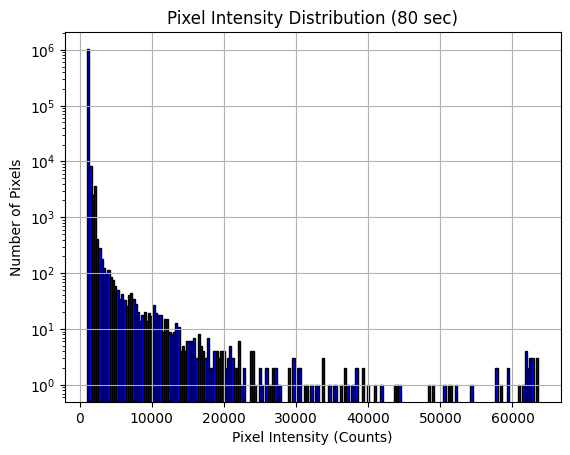

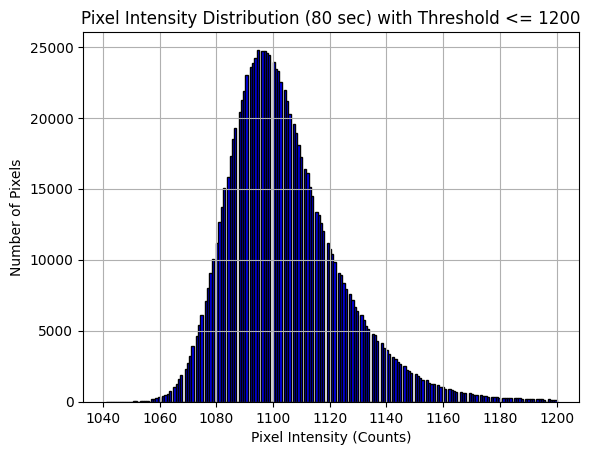

In [14]:
def plot_pixel_intensity_distribution(stacked_frames, exposure_times, filtered_exposure_times, threshold=1200):
    """
    Plot the pixel intensity distribution of dark frames, both unfiltered and filtered by a specified threshold for each exposure time.

    :param stacked_frames: Stacked frames (3D numpy array) where the first frame is the bias, followed by dark frames.
    :type stacked_frames: np.ndarray
    :param exposure_times: List of exposure times for the dark frames.
    :type exposure_times: list
    :param filtered_exposure_times: List of exposure times to filter and plot, including the bias frame (0).
    :type filtered_exposure_times: list
    :param threshold: The threshold for filtering pixel intensities (default is 2200).
    :type threshold: float
    :return: The two plots showing pixel intensity distributions (unfiltered and filtered).
    :rtype: None
    """
    # Process each filtered frame individually
    for exposure_time in filtered_exposure_times:
        # Get the index of the current exposure time
        i = exposure_times.index(exposure_time)
        # Select the frame for the current exposure time
        frame = stacked_frames[i]  # Use i directly for the bias and dark frames
        # Flatten the frame data into a 1D array
        flattened_data = frame.flatten()
        
        # Plot the histogram of pixel intensities for the frame (unfiltered)
        plt.figure()
        plt.hist(flattened_data, bins=200, 
                 range=(np.min(flattened_data), np.max(flattened_data)), 
                 log=True, color='blue', edgecolor='black')
        plt.title(f'Pixel Intensity Distribution ({exposure_time} sec)')
        plt.xlabel('Pixel Intensity (Counts)')
        plt.ylabel('Number of Pixels')
        plt.grid(True)
        plt.show()
        
        # Filter the data based on the threshold
        filtered_data = flattened_data[flattened_data <= threshold]
        
        # Plot the histogram of pixel intensities for the filtered frame
        plt.figure()
        plt.hist(filtered_data, bins=200, 
                 range=(np.min(filtered_data), np.max(filtered_data)), 
                 color='blue', edgecolor='black')
        plt.title(f'Pixel Intensity Distribution ({exposure_time} sec) with Threshold <= {threshold}')
        plt.xlabel('Pixel Intensity (Counts)')
        plt.ylabel('Number of Pixels')
        plt.grid(True)
        plt.show()

# Example usuage of playing around with exposure times
filtered_exposure_times = [80] # Only putting one time here to make the output not cluttered with graphs
# Call the function
plot_pixel_intensity_distribution(stacked_frames, list_of_exposure_times, filtered_exposure_times)

We proceed to calculate key statistical metrics—namely the mean, standard deviation, and statistical uncertainty of the mean—for each stacked image. Each frame is processed by first flattening the 2D pixel data into a 1D array, and subsequently filtering the pixel values using pre-defined thresholds specific to each frame. The mean value reflects the average signal level in the filtered data, providing an estimate of the dark current or bias level, while the standard deviation quantifies the dispersion of pixel intensities, which corresponds to the noise characteristics of the sensor. Statistical uncertainty is determined under the assumption that each pixel represents an independent measurement of the mean, thereby providing insight into the reliability of the average signal measurement. Interestingly, the statistical uncertainty associated with the dark frame taken at an 80-second exposure time deviates from the expected linear relationship observed for the other frames. If this discrepancy persists even after recalculating the statistics without applying the filtering thresholds, it will warrant further investigation in the subsequent analysis.

In [15]:
def calculate_statistics_with_filters(stacked_frames):
    """
    Calculate mean, standard deviation, and statistical uncertainty for each frame in the stacked frames,
    after applying specified filter ranges.

    :param stacked_frames: Stacked frames (3D numpy array) where the first frame is the bias, followed by dark frames.
    :type stacked_frames: np.ndarray
    :return: Lists of mean counts, standard deviations, and statistical uncertainties for each frame.
    :rtype: tuple (list, list, list)
    """
    # Define the filter ranges for each frame
    filter_ranges = [1050, 1100, 1150, 1175, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600] 
    mean_counts_lim = []
    st_devs_lim = []
    stat_uncs_lim = []
    # Loop through each frame in the stacked frames
    for i, frame in enumerate(stacked_frames):
        filter_max = filter_ranges[i]
        # Flatten the frame data into a 1D array
        flattened_data = frame.flatten()
        # Filter data based on the filter range
        filtered_data = flattened_data[flattened_data <= filter_max]
        # Calculate mean, standard deviation, and statistical uncertainty if there is data
        if filtered_data.size > 0:
            mean = np.mean(filtered_data)
            st_dev = stats.tstd(filtered_data, ddof=1)
            stat_unc = mean / np.sqrt(len(filtered_data))
        else:
            mean = st_dev = stat_unc = np.nan  # Handle the case where filtered data is empty
        mean_counts_lim.append(mean)
        st_devs_lim.append(st_dev)
        stat_uncs_lim.append(stat_unc)
        # Print results for each frame
        print(f"Exposure Time: {list_of_exposure_times[i]} sec, Max Filter: {filter_max}")
        print(f"Mean Counts: {mean}, Standard Deviation: {st_dev}, Statistical Uncertainty: {stat_unc}")

    return mean_counts_lim, st_devs_lim, stat_uncs_lim

# Example usage
mean_counts_lim, st_devs_lim, stat_uncs_lim = calculate_statistics_with_filters(stacked_frames)

Exposure Time: 0 sec, Max Filter: 1050
Mean Counts: 1002.9957325339666, Standard Deviation: 7.718027122092835, Statistical Uncertainty: 0.9796809712977722
Exposure Time: 10 sec, Max Filter: 1100
Mean Counts: 1010.1488989867025, Standard Deviation: 9.999483271839612, Statistical Uncertainty: 0.9876917380178544
Exposure Time: 20 sec, Max Filter: 1150
Mean Counts: 1017.6860052651863, Standard Deviation: 11.97042134896486, Statistical Uncertainty: 0.9964497660719639
Exposure Time: 30 sec, Max Filter: 1175
Mean Counts: 1025.4031046223758, Standard Deviation: 14.020409261780175, Statistical Uncertainty: 1.0046518383226528
Exposure Time: 40 sec, Max Filter: 1200
Mean Counts: 1032.9444243122728, Standard Deviation: 15.854883867936822, Statistical Uncertainty: 1.0127164072713395
Exposure Time: 50 sec, Max Filter: 1250
Mean Counts: 1040.1021468846195, Standard Deviation: 18.92105026505923, Statistical Uncertainty: 1.0196437959014584
Exposure Time: 60 sec, Max Filter: 1300
Mean Counts: 1047.81881

Now the following function calculates statistical metrics, specifically the mean, standard deviation, and statistical uncertainty for each frame in the stacked image data, without applying any filtering to the pixel values. The methodology of reading the stacked frames and calcualting the statistical measurements remain the same as from the previous function.

In [16]:
def calculate_statistics_without_filters(stacked_frames):
    """
    Calculate mean, standard deviation, and statistical uncertainty for each frame in the stacked frames,
    without applying any specified filter ranges.

    :param stacked_frames: Stacked frames (3D numpy array) where the first frame is the bias, followed by dark frames.
    :type stacked_frames: np.ndarray
    :return: Lists of mean counts, standard deviations, and statistical uncertainties for each frame.
    :rtype: tuple (list, list, list)
    """    
    mean_counts_whole = []
    st_devs_whole = []
    stat_uncs_whole = []

    # Loop through each frame in the stacked frames
    for i, frame in enumerate(stacked_frames):
        # Flatten the frame data into a 1D array
        flattened_data = frame.flatten()
        # Calculate mean, standard deviation, and statistical uncertainty if there is data
        if flattened_data.size > 0:
            mean = np.mean(flattened_data)
            st_dev = stats.tstd(flattened_data, ddof=1)
            stat_unc = mean / np.sqrt(len(flattened_data))
        else:
            mean = st_dev = stat_unc = np.nan  # Handle the case where flattened data is empty

        mean_counts_whole.append(mean)
        st_devs_whole.append(st_dev)
        stat_uncs_whole.append(stat_unc)

        # Print results for each frame
        print(f"Exposure Time: {list_of_exposure_times[i]} sec")
        print(f"Mean Counts: {mean}, Standard Deviation: {st_dev}, Statistical Uncertainty: {stat_unc}")

    return mean_counts_whole, st_devs_whole, stat_uncs_whole

# Call the function 
mean_counts_whole, st_devs_whole, stat_uncs_whole = calculate_statistics_without_filters(stacked_frames)

Exposure Time: 0 sec
Mean Counts: 1003.057149887085, Standard Deviation: 14.869272117575331, Statistical Uncertainty: 0.9795479979366064
Exposure Time: 10 sec
Mean Counts: 1011.3171682357788, Standard Deviation: 98.23146788071946, Statistical Uncertainty: 0.9876144221052527
Exposure Time: 20 sec
Mean Counts: 1020.2279901504517, Standard Deviation: 123.83317820423197, Statistical Uncertainty: 0.9963163966313004
Exposure Time: 30 sec
Mean Counts: 1029.3027658462524, Standard Deviation: 156.6409813639801, Statistical Uncertainty: 1.005178482271731
Exposure Time: 40 sec
Mean Counts: 1038.3151874542236, Standard Deviation: 191.37723182264267, Statistical Uncertainty: 1.0139796752482653
Exposure Time: 50 sec
Mean Counts: 1046.6994800567627, Standard Deviation: 230.4463528375717, Statistical Uncertainty: 1.0221674609929323
Exposure Time: 60 sec
Mean Counts: 1055.6110725402832, Standard Deviation: 258.9103370397622, Statistical Uncertainty: 1.0308701880276203
Exposure Time: 70 sec
Mean Counts:

The code below features two functions designed to calculate and plot statistical uncertainties associated with data collected at various exposure times during a stacked imaging process. The first function, `plot_statistical_uncertainty_including_80`, visualizes the statistical uncertainties for all exposure times, while the second function, `plot_statistical_uncertainty_excluding_80`, generates a similar plot but omits the 80-second point, which exhibited a significantly higher statistical uncertainty compared to the other measurements. By comparing the statistical uncertainties across both ranges, we can observe how uncertainty varies with exposure time, shedding light on the influence of systematic uncertainties in our dataset. The consistent uncertainties across most exposure times suggest that statistical uncertainty predominates, indicating a reliable measurement process and that the statistical uncertainty dominates over any systematic effects.

However, this trend does not hold true for the 80-second point, as shown by the two graphs. Its unusual level of statistical uncertainty diverges from the expected positive linear relationship between exposure time and uncertainty. Including this outlier could distort the overall analysis and lead to erroneous conclusions. The anomaly is further supported by the consistent CCD temperature observed in the other stacked images (all being at $0^\circ \text{C}$), implying that the 80-second frame likely experienced a systematic error rather that dominates significantly over the random statistical fluctuations. Possible causes of this systematic error may include detector saturation, where the signal exceeds the maximum measurable range, or calibration errors specific to that exposure time. 

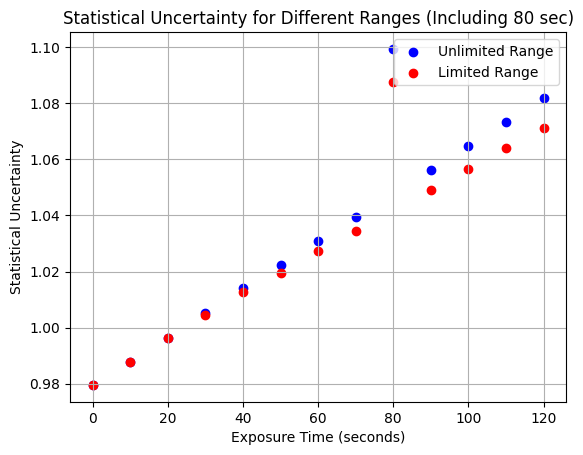

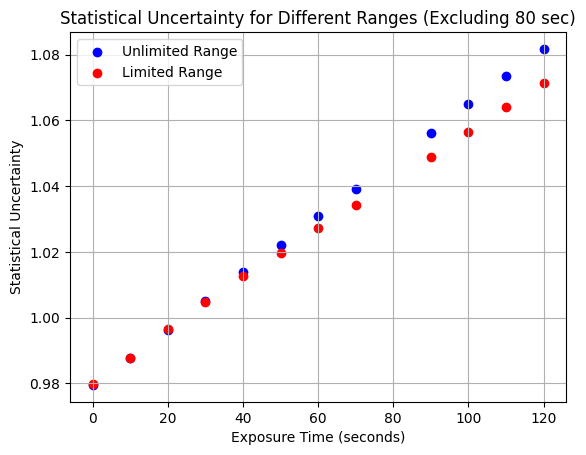

In [17]:
def plot_statistical_uncertainty_including_80(stat_uncs_whole, stat_uncs_lim):
    """
    Plot the statistical uncertainties for different ranges, including the 80 seconds exposure time.

    :param stat_uncs_whole: List of statistical uncertainties calculated without filter ranges.
    :type stat_uncs_whole: list
    :param stat_uncs_lim: List of statistical uncertainties calculated with filter ranges.
    :type stat_uncs_lim: list
    :return: Plot of statistical uncertainties for different ranges of exposure times. 
    :rtype: None
    """
    plt.scatter(list_of_exposure_times, stat_uncs_whole, label="Unlimited Range", color='blue')
    plt.scatter(list_of_exposure_times, stat_uncs_lim, label="Limited Range", color='red')
    plt.title("Statistical Uncertainty for Different Ranges (Including 80 sec)")
    plt.xlabel("Exposure Time (seconds)")
    plt.ylabel("Statistical Uncertainty")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_statistical_uncertainty_excluding_80(stat_uncs_whole, stat_uncs_lim):
    """
    Plot the statistical uncertainties for different ranges, excluding the 80 seconds exposure time.

    :param stat_uncs_whole: List of statistical uncertainties calculated without filter ranges.
    :type stat_uncs_whole: list
    :param stat_uncs_lim: List of statistical uncertainties calculated with filter ranges.
    :type stat_uncs_lim: list
    :return: Plot of statistical uncertainties for different ranges of exposure times. 
    :rtype: None 
    """
    # Filter out the 80 seconds for the plot
    filtered_stat_uncs_whole = [stat for i, stat in enumerate(stat_uncs_whole) if list_of_exposure_times[i] != 80]
    filtered_stat_uncs_lim = [stat for i, stat in enumerate(stat_uncs_lim) if list_of_exposure_times[i] != 80]
    filtered_times = [time for time in list_of_exposure_times if time != 80]

    plt.scatter(filtered_times, filtered_stat_uncs_whole, label="Unlimited Range", color='blue')
    plt.scatter(filtered_times, filtered_stat_uncs_lim, label="Limited Range", color='red')
    plt.title("Statistical Uncertainty for Different Ranges (Excluding 80 sec)")
    plt.xlabel("Exposure Time (seconds)")
    plt.ylabel("Statistical Uncertainty")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the functions
plot_statistical_uncertainty_including_80(stat_uncs_whole, stat_uncs_lim)
plot_statistical_uncertainty_excluding_80(stat_uncs_whole, stat_uncs_lim)

The code below performs a linear regression on the mean counts of data collected at various exposure times while excluding the 80-second data point due to its anomalous statistical uncertainty. We chose to plot the points that were filtered to have a limited range since they exhibit less statistical uncertainties then not filtering. The slope of the fitted line directly corresponds to the dark current rate, which requires adjustment by the gain given by the STL-1001 CCD camera's manuscript to convert the slope into the actual dark current rate expressed in electrons per pixel per second ($e^{-}$/p/s). Additionally, this linear fit provides insights into the bias of the camera. The bias represents the constant offset in the measurements, contributing to the overall mean counts. Upon visual inspection, the linear model aligns exceptionally well with the data points, excluding the outlier at 80 seconds. This observation is significant reinforces one-to-one correspondence between photons and electrons in a CCD sensor. 

Dark Current Rate: 0.751 ± 0.001 e-/p/s
Offset: 1002.761 ± 0.089
Percentage Error between Measured and Actual Dark Current: 91.65%


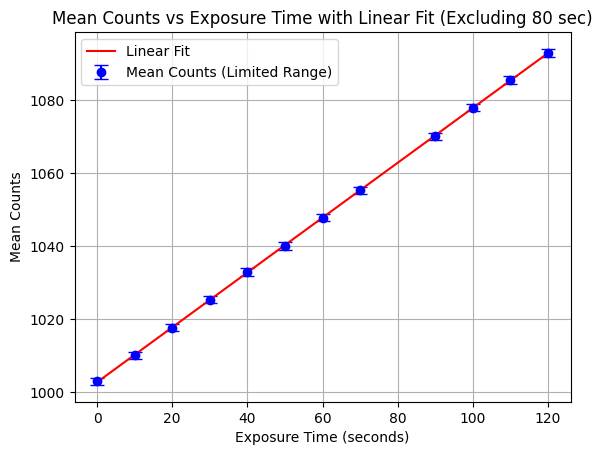

In [18]:
def linear_model(exposure, dark_current_rate, offset):
    """
    Compute the predicted mean counts for a given exposure time based on a linear model.

    :param exposure: The amount of time the frame was exposed (in seconds).
    :type exposure: (array-like)
    :param dark_current_rate: The rate at which dark current accumulates (in e-/p/s).
    :type dark_current_rate: float
    :param offset: The number of electrons the measurements are offset by.
    :type offset: float 
    :return: The predicted mean counts for the given exposure times based on the linear model.
    :rtype: np.ndarray
    """
    return dark_current_rate * exposure + offset

def linear_fit_without_80(exposure_times, mean_counts_lim, stat_uncs_lim):
    """
    Perform linear regression on mean counts excluding the 80-second exposure time
    and plot the results. Calculate the percentage error between measured and actual dark current.

    :param exposure_times: List of exposure times including the 80 seconds.
    :type exposure_times: list
    :param mean_counts_lim: List of mean counts for each exposure time, excluding 80 seconds.
    :type mean_counts_lim: list
    :param stat_uncs_lim: List of statistical uncertainties for each mean count.
    :type stat_uncs_lim: list
    :return: Tuple containing the adjusted dark current rate and its uncertainty, along with the offset and its uncertainty.
    :rtype: tuple
    """
    # Filter out the 80-second exposure time
    filtered_exposure_times = [time for time in exposure_times if time != 80]
    filtered_mean_counts_lim = [mean for i, mean in enumerate(mean_counts_lim) if exposure_times[i] != 80]
    filtered_stat_uncs_lim = [stat for i, stat in enumerate(stat_uncs_lim) if exposure_times[i] != 80]
    # Perform linear regression
    params, covariance = optimize.curve_fit(linear_model, filtered_exposure_times, filtered_mean_counts_lim)
    dark_current_rate, offset = params
    uncertainty_in_dcr = np.sqrt(covariance[0][0])
    uncertainty_in_offset = np.sqrt(covariance[1][1])
    # Calculate dark current rate and its uncertainty 
    dark_current_rate_gain_adjusted = dark_current_rate
    dark_current_rate_uncertainty = uncertainty_in_dcr
    # Actual dark current at 0°C (given in spec manual)
    actual_dark_current = 9  # e-/p/s
    # Calculate percentage error between measured and actual dark current
    difference = np.abs(dark_current_rate_gain_adjusted - actual_dark_current)
    percentage_error = (difference / actual_dark_current) * 100
    # Print results
    print(f"Dark Current Rate: {dark_current_rate_gain_adjusted:.3f} ± {dark_current_rate_uncertainty:.3f} e-/p/s")
    print(f"Offset: {offset:.3f} ± {uncertainty_in_offset:.3f}")
    print(f"Percentage Error between Measured and Actual Dark Current: {percentage_error:.2f}%")

    # Generate fitted values
    fitted_counts = linear_model(np.array(filtered_exposure_times), *params)
    # Plot the mean counts against exposure time
    plt.figure()
    plt.errorbar(filtered_exposure_times, filtered_mean_counts_lim, yerr=filtered_stat_uncs_lim, fmt='o',
                 label='Mean Counts (Limited Range)', color='blue', capsize=5)
    plt.plot(filtered_exposure_times, fitted_counts, 'r-', label='Linear Fit')
    plt.title('Mean Counts vs Exposure Time with Linear Fit (Excluding 80 sec)')
    plt.xlabel('Exposure Time (seconds)')
    plt.ylabel('Mean Counts')
    plt.legend()
    plt.grid(True)
    plt.show()

    return dark_current_rate_gain_adjusted, dark_current_rate_uncertainty, offset, uncertainty_in_offset

# Call the function 
dark_current_rate, dark_current_rate_uncertainty, offset, offset_uncertainty = linear_fit_without_80(list_of_exposure_times, mean_counts_lim, stat_uncs_lim)

Our measured dark current rate is $0.751 \pm 0.001$ $e^{-}$/p/s, with the uncertainty derived from the covariance matrix of the fit. The percentage error between our measured value and the expected dark current rate of 9 $e^{-}$/p/s at $0^\circ \text{C}$ is 91.65%. This significant discrepancy indicates that our measurement does not agree with the expected value, suggesting inconsistency with the manufacturer's specifications. Possible reasons for this inconsistency could include calibration issues, environmental conditions deviating from the specified temperature, or systematic errors in the measurement process. These systematic errors are most likely the same that caused us to get rid of the 80 second exposure point in the prior cells.

We proceed with computing the residuals of the mean counts of the dark frames, specifically excluding the from the 80-second exposure time dark frame. It calls the mean counts and their corresponding statistical uncertainties, obtained from previous function `function calculate_statistics_with_filters`, alongside the dark current rate and offset derived from previous function `linear_fit_without_80`. To calculate the residuals, the code iterates through the filtered mean counts, using function `linear_model` to predict expected mean counts based on the corresponding exposure times. The residuals are determined by subtracting these predicted values from the observed mean counts, yielding the differences that indicate how far off the model's predictions are. Subsequently, the code assesses the significance of these residuals by calculating their distances in terms of standard deviations (sigmas), which allows for quantifying how extreme each residual is relative to the statistical uncertainties of the mean counts. Statistics where calcualted using Numpy built-in functions. Then, a plot of the resdiauls against exposure time, feqturing a zero residual line is presented for easy reference. 

The farthest mean count is 0.265 sigmas away.


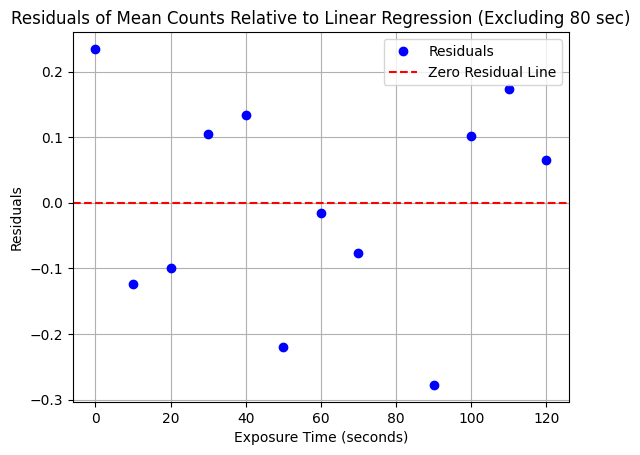

In [19]:
def calculate_and_plot_residuals(exposure_times, mean_counts_lim, stat_uncs_lim, dark_current_rate, offset):
    """
    Calculate residuals from the linear model and plot them, excluding the 80-second exposure time.
    
    :param exposure_times: List of exposure times (in seconds).
    :type exposure_times: list
    :param mean_counts_lim: List of mean counts corresponding to the exposure times.
    :type mean_counts_lim: list
    :param stat_uncs_lim: List of statistical uncertainties corresponding to the mean counts.
    :type stat_uncs_lim: list
    :param dark_current_rate: Dark current rate obtained from the linear fit (in e-/p/s).
    :type dark_current_rate: float
    :param offset: Offset obtained from the linear fit.
    :type offset: float
    :return: The maximum distance of residuals in terms of sigmas and the corresponding mean count.
    :rtype: tuple
    """
    # Exclude the 80-second exposure time
    filtered_exposure_times = [time for time in exposure_times if time != 80]
    filtered_mean_counts_lim = [mean for i, mean in enumerate(mean_counts_lim) if exposure_times[i] != 80]
    filtered_stat_uncs_lim = [stat for i, stat in enumerate(stat_uncs_lim) if exposure_times[i] != 80]
    # Calculate residuals by subtracting predicted values from observed mean counts
    residuals = []
    for i, count in enumerate(filtered_mean_counts_lim):
        predicted_value = linear_model(filtered_exposure_times[i], dark_current_rate, offset)
        distance = count - predicted_value
        residuals.append(distance)
    # Calculate the distance of residuals in terms of sigmas
    sigma_distances = np.abs(residuals) / np.array(filtered_stat_uncs_lim)
    # Output the farthest mean count in terms of sigmas
    farthest_sigma = np.max(sigma_distances)
    farthest_index = np.argmax(sigma_distances)
    farthest_mean_count = filtered_mean_counts_lim[farthest_index]
    print(f"The farthest mean count is {farthest_sigma:.3f} sigmas away.")
    # Plot the residuals
    plt.figure()
    plt.plot(filtered_exposure_times, residuals, 'o', color='blue', label='Residuals')
    plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    plt.title('Residuals of Mean Counts Relative to Linear Regression (Excluding 80 sec)')
    plt.xlabel('Exposure Time (seconds)')
    plt.ylabel('Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()

    return farthest_sigma, farthest_mean_count

# Call the function 
farthest_sigma_info, farthest_mean_count_info = calculate_and_plot_residuals(
    list_of_exposure_times, mean_counts_lim, stat_uncs_lim, dark_current_rate, offset
)

From analyzing the plot above, it is evident that the data points do not consistently follow the zero residual line; rather, they appear to be scattered randomly across both the positive and negative sides of this line. This random scattering suggests that the linear relationship established by the current model does not adequately represent the underlying data. Given this observation, it may be beneficial to explore alternative modeling approaches that could better capture the relationship between exposure times and mean counts. For instance, implementing a polynomial regression model could potentially provide a more accurate fit to the data, as it allows for curvature that a linear model cannot accommodate. Different regression techniques such as exponential modeling might also yield better results. 

This function below calculates the dark current of a CCD camera by analyzing the bias and dark frame (120 second exposure time) data obtained at a temperature of $10^\circ \text{C}$. It loads the respective FITS files filters the pixel values based on the values listed in the `filter_ranges` array defined in the  `calculate_statistics_with_filters function`, and computes the mean and standard deviation of the counts to determine the dark current. In this implementation, the dark current is calculated between two end points of the relationship, based on the mean counts from the bias and dark frames. This approach contrasts with a previous analysis that employed a linear fit model, utilizing a more extensive dataset of dark frames corresponding to exposure times up to 120 seconds (12 points). Consequently, this current implementation is more rudimentary than the earlier analysis.

Dark Current Rate: 3.237 ± 0.014 e-/p/s
Percentage Error between Measured and Actual Dark Current: 64.03%


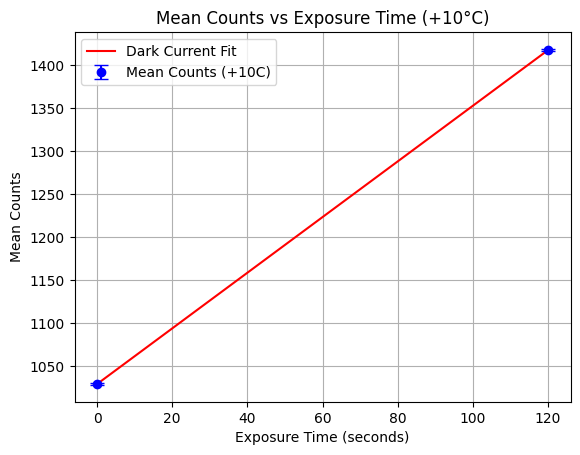

In [20]:
def calculate_dark_current_and_plot(bias_file, dark_file, bias_filter_max, dark_filter_max, exposure_time_dark):
    """
    Load bias and dark frame data taken at the different temperature of 10°C, 
    calculate dark current between the two points, and plot the results.

    :param bias_file: Path to the bias frame FITS file.
    :type bias_file: str
    :param dark_file: Path to the dark frame FITS file.
    :type dark_file: str
    :param bias_filter_max: Maximum value to filter the bias frame data.
    :type bias_filter_max: float
    :param dark_filter_max: Maximum value to filter the dark frame data.
    :type dark_filter_max: float
    :param exposure_time_dark: Exposure time of the dark frame (in seconds).
    :type exposure_time_dark: float
    :return: The calculated dark current and its uncertainty.
    :rtype: tuple
    """
    # Load the bias frame data
    with fits.open(bias_file) as hdul_bias:
        bias_data = hdul_bias[0].data
    bias_flat_data = bias_data.flatten()
    # Load the dark frame data
    with fits.open(dark_file) as hdul_dark:
        dark_data = hdul_dark[0].data
    dark_flat_data = dark_data.flatten()
    # Filter the bias and dark frame data
    bias_filtered = bias_flat_data[bias_flat_data <= bias_filter_max]
    dark_filtered = dark_flat_data[dark_flat_data <= dark_filter_max]

    # Calculate statistics for the bias frame
    mean_bias = np.mean(bias_filtered)
    stat_unc_bias = mean_bias / np.sqrt(len(bias_filtered))
    # Calculate statistics for the dark frame
    mean_dark = np.mean(dark_filtered)
    stat_unc_dark = mean_dark / np.sqrt(len(dark_filtered))

    # Calculate dark current and its uncertainty
    dark_current = (mean_dark - mean_bias) / exposure_time_dark
    uncertainty_dark_current = np.sqrt(stat_unc_dark**2 + stat_unc_bias**2) / exposure_time_dark
    # Actual dark current at 0°C (given in spec manual)
    actual_dark_current = 9  # e-/p/s
    # Calculate percentage error between measured and actual dark current
    difference = np.abs(dark_current - actual_dark_current)
    percentage_error = (difference / actual_dark_current) * 100
    # Print the calculated dark current and its uncertainty
    print(f"Dark Current Rate: {dark_current:.3f} ± {uncertainty_dark_current:.3f} e-/p/s")
    print(f"Percentage Error between Measured and Actual Dark Current: {percentage_error:.2f}%")

    # Prepare for plotting
    exposure_times = [0, exposure_time_dark]
    mean_counts = [mean_bias, mean_dark]
    stat_uncs = [stat_unc_bias, stat_unc_dark]
    # Generate predicted counts
    predicted_counts = linear_model(np.array(exposure_times), dark_current, mean_bias)
    # Plot mean counts vs. exposure time
    plt.figure()
    plt.errorbar(exposure_times, mean_counts, yerr=stat_uncs, fmt='o', color='blue', capsize=5, label='Mean Counts (+10C)')
    plt.plot(exposure_times, predicted_counts, color='red', label='Dark Current Fit')
    plt.title('Mean Counts vs Exposure Time (+10°C)')
    plt.xlabel('Exposure Time (seconds)')
    plt.ylabel('Mean Counts')
    plt.legend()
    plt.grid(True)
    plt.show()

    return dark_current, uncertainty_dark_current

# File paths for the Bias Frame and Dark Frame at +10°C
bias_file_10C = r"..\FITS_Files\3.2.4_bias_frame_+10C.00000000.BIAS.FIT"
dark_file_10C_120s = r"..\FITS_Files\3.2.4_dark_frame_120_sec_+10C.00000000.DARK.FIT"

# Define filter limits
bias_filter_max = 1050
dark_filter_max = 1600
exposure_time_dark = 120  # seconds

# Call the function
dark_current_info = calculate_dark_current_and_plot(bias_file_10C, dark_file_10C_120s, bias_filter_max, dark_filter_max, exposure_time_dark)

We see that the measured dark current at $10^\circ \text{C}$ is observed to be to 3.237 ± 0.014 $e^{-}$/p/s. This is a significant increase from the measured dark current at $0^\circ \text{C}$ for a greater exposure time range, where we previously measured 0.751 ± 0.001 $e^{-}$/p/s. This change can be attributed to the temperature sensitivity of the CCD sensor. Dark current is primarily caused by thermally generated electrons, which increase with temperature. Higher temperatures provide more energy to the semiconductor material, resulting in a higher rate of electron generation, thus elevating the dark current. In addition, the percentage error between our measured value and the expected dark current rate of 9 $e^{-}$/p/s at $0^\circ \text{C}$ is 64.03%. So like our mesaured dark current at $0^\circ \text{C}$, there is an inconsistency with the manufacturer's specifications as our mesaurent does not agree with the expected value.


## Section 4.3: Imaging flat-fields
 A **flat-field** is an image taken across a uniform light source, such as the twilight sky or a flat-field lamp. The purpose of acquiring a flat field is to correct for variations in relative sensitivity of the pixels in the CCD sensor. If not accounted for, it can cause uneven exposures, resulting in artifacts like banding, hot pixels, and inaccurate brightness measurements caused by dust and vignetting. By normalizing the pixel intensity across the pixels and then dividing it from the corresponding light frames, astronomers can improve the quality of their images and data. 
##### Section 4.3.1: 
We begin this section by cerating a master flat-field image through the median-combination of multiple flat-field frames. Alongside this, we generate a master dark frame that is captured with the same exposure time and filter as the flat-field images. This step is essential for accurately subtracting the dark frame's effects from the master flat-field. The methodology employed in this process mirrors that of our previous functions, where we stack the 2D images into a 3D NumPy array, facilitating easier manipulation and analysis of the data.


In [21]:
def create_median_flat(file_template, dark_file_template, start_index, end_index):
    """
    Create a median flat field by median-combining flat field frames and subtracting the median dark frame.

    :param file_template: Template path for the flat field files with placeholders for the frame number.
    :type file_template: str
    :param dark_file_template: Template path for the dark frame files with placeholders for the frame number.
    :type dark_file_template: str
    :param start_index: The starting index for the flat field frames.
    :type start_index: int
    :param end_index: The ending index for the flat field frames.
    :type end_index: int
    :return: Master flat field (2D np.ndarray), Stack of individual flat fields (3D np.ndarray)
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # List to store the data from each flat field and dark frame
    flat_fields_data = []
    dark_frames_data = []
    # Loop through each frame and read both flat field and dark frame data
    for i in range(start_index, end_index + 1):
        # Construct the file name for the flat field
        flat_file_path = file_template.format(i)
        # Open the flat field FITS file and extract the data
        with fits.open(flat_file_path) as hdul:
            flat_fields_data.append(hdul[0].data)
        # Construct the file name for the dark frame
        dark_file_path = dark_file_template.format(i)
        # Open the dark frame FITS file and extract the data
        with fits.open(dark_file_path) as hdul_dark:
            dark_frames_data.append(hdul_dark[0].data)
    # Stack the frames into 3D arrays (stack of 2D frames)
    stacked_flat_frames = np.stack(flat_fields_data, axis=0)
    stacked_dark_frames = np.stack(dark_frames_data, axis=0)
    # Calculate the median across the flat frames (axis=0)
    master_flat_frame = np.median(stacked_flat_frames, axis=0)
    # Calculate the median across the dark frames (axis=0)
    median_dark_frame = np.median(stacked_dark_frames, axis=0)
    # Subtract the median dark frame from the master flat frame
    master_flat_field_corrected = master_flat_frame - median_dark_frame

    return master_flat_field_corrected, stacked_flat_frames

# Template for the flat field file names (with placeholder)
flat_file_template = r"..\FITS_Files\3.3.4_3_flat_fields_10_sec_BLUE.{:08d}.FLAT.FIT"
# Template for the dark frame file names (with placeholder)
dark_file_template = r"..\FITS_Files\3.3.4_3_dark_frames_10_sec_BLUE.{:08d}.DARK.FIT"

# Defining the starting and ending indexes for both flat fields and dark frames
start_index = 0 
end_index = 9

# Call the function
master_flat_field_corrected, stacked_flat_frames = create_median_flat(flat_file_template, dark_file_template, start_index, end_index)

The function below normalizes the median flat field, which has already been corrected for the median dark frame, by dividing each pixel by the mode of its pixel values. The mode is used because it represents the most frequently occurring value, which in a well-exposed flat field corresponds to the typical sensitivity level across the detector. The process begins by flattening the median flat field into a 1D NumPy array, followed by calculating the mode using the `scipy.stats` library. The resulting FITS file is saved to my local computer so that I conduct further analysis in SAOImage DS9. The reasoning for doing so will be discussed in the next subsection. This normalization ensures that any photometric analysis on the corrected images is accurate, minimizing artifacts caused by non-uniform pixel sensitivity.

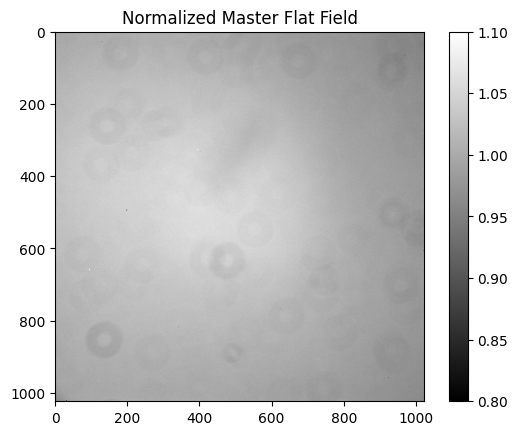

In [22]:
def normalize_flat_field(median_flat_field, save_path):
    """
    Normalize the median flat field by dividing by the mode of its pixel values and scaling 
    appropriately.

    :param median_flat_field: The median flat field to be normalized.
    :type median_flat_field: np.ndarray
    :param save_path: Path to save the scaled normalized flat field FITS file.
    :type save_path: str
    :return: Scaled and normalized flat field.
    :rtype: np.ndarray
    """
    # Flatten the median flat field to 1D for mode calculation
    flat_median = median_flat_field.flatten()
    # Calculate the mode of the flattened median values
    mode_value = stats.mode(flat_median, keepdims=True)[0][0]
    # Normalize the median flat field by dividing by the mode
    norm_flat = median_flat_field / mode_value
    # Plot the normalized flat field
    plt.imshow(norm_flat, cmap='gray', vmin=0.8, vmax=1.1)
    plt.colorbar()
    plt.title("Normalized Master Flat Field")
    plt.show()

    # Save the scaled normalized flat field as a FITS file
    hdu = fits.PrimaryHDU(norm_flat)
    hdu.writeto(save_path, overwrite=True)

    return norm_flat

# Define the path to save the scaled normalized flat field
# Change this to a path that works for you when running it! 
save_path = r"..\FITS_Files\scaled_norm_flats.fits"
# Call the function
norm_flat = normalize_flat_field(master_flat_field_corrected, save_path)

##### Sections 4.3.2 & 4.3.3:
The next two subsections of the analysis are based on the same function and methodology. So I'll combine both of the descriptions into one.

The function is designed to assess the brightness characteristics of different regions in a normalized master flat field image. This assessment is performed by comparing the noramlized pixel values from specific locations: the brightest and darkest regions (Section 4.3.2), and the center and corner (Section 4.3.3). Since the goal is to quantify the overall brightness level of each region and then compare it to other areas, we will record the mean as our norm values for the four regions: The mean provides a more straightforward representation of the average light level. 

To gather the necessary normalized values for this analysis, we utilized SAOImage DS9 to open the normalized corrected master flat field image. A circular region with a radius of 50 pixels was defined in physical units. For Section 4.3.2, we moved the region to identify an area with the lowest mean normalized value and recorded its mean value. In a similar manner, I visually searched for the brightest region to record its mean value. For Section 4.3.3, I centered the region at (512, 512) in physical units to obtain the mean value at the center of the image. Although the lab manual did not require it, I also explored the four corners and averaged those results. This was done to ensure the robustness of our data by accounting for potential variations across the image.

In [23]:
def quantify_flat_field_regions(center_norm, corner_values, brightest_norm, darkest_norm):
    """
    Quantify the properties of various regions in a normalized master flat field by comparing the brightness
    of specific regions (center, corners, brightest, and darkest parts).

    :param center_norm: The normalized value at the center of the flat field.
    :type center_norm: float
    :param corner_values: The normalized values at the four corners of the flat field.
    :type corner_values: list or np.ndarray
    :param brightest_norm: The normalized value of the brightest region in the flat field.
    :type brightest_norm: float
    :param darkest_norm: The normalized value of the darkest region in the flat field.
    :type darkest_norm: float
    :return: A dictionary containing average corner value, bright-dark ratio, center-corner ratio, and magnitude difference.
    :rtype: dict
    """
    # Calculate the average value of the corner norms
    average_corner_norm = np.mean(corner_values)
    # Calculate the ratio of brightness between the brightest and darkest areas
    bright_dark_ratio = darkest_norm / brightest_norm 
    # Calculate the ratio of the center norm to the average corner norm
    center_corner_ratio = center_norm / average_corner_norm
    # Calculate the magnitude difference
    loc_mag = -2.5 * np.log10(center_corner_ratio)
    # Print results
    print(f"Average norm of the corners: {average_corner_norm:.5f}")
    print(f"Ratio of brightness between the brightest and darkest areas: {bright_dark_ratio:.5f}")
    print(f"Difference in magnitude between the center and average corner values: {loc_mag:.5f}")
    # Return results as a dictionary
    results = {
        'average_corner_norm': average_corner_norm,
        'bright_dark_ratio': bright_dark_ratio,
        'center_corner_ratio': center_corner_ratio,
        'loc_mag': loc_mag
    }

    return results

# Values obtained for analysis in Sections 4.4.2 and 4.4.3
# For each normalized value, a circular region with a radius of 50 pixels was defined in DS9.
# The pixel values represent "physical" units of light intensity.
center_norm = 1.0523  # Normalized value at the center of the region located at (512, 512)
corner_values = np.array([0.997657, 0.956846, 0.985577, 0.965137])  # Normalized values at the corners:
# (0, 0), (1024, 0), (0, 1024), (1024, 1024)
brightest_norm = 1.0577  # Normalized value at the center of the brightest region located at (412.6064, 534.6928)
darkest_norm = 0.956058  # Normalized value at the center of the darkest region located at (315.008, 597.0176)

# Call the function
results = quantify_flat_field_regions(center_norm, corner_values, brightest_norm, darkest_norm)

Average norm of the corners: 0.97630
Ratio of brightness between the brightest and darkest areas: 0.90390
Difference in magnitude between the center and average corner values: -0.08139


##### Result for Section 4.3.2: 
Using the results from SAOImage DS9, the ratio of brightness between the brightest and darkest areas of the flat field is determined by the formula:
$$
\text{Brightness Ratio} = \frac{\text{Darkest Norm}}{\text{Brightest Norm}} = 0.90390
$$
This result indicates that the darkest region receives approximately **9.61%** less light than the darkest region. The significance of this finding lies in the minimal variation in brightness across the image, suggesting that the flat field is well-calibrated and exhibits consistent sensitivity across the detector.

##### Result for Section 4.3.3: 
The difference in observed magnitude between placing the star at the center of the image, rather than at the corners is determined by the formula:
$$
\Delta m = m_{\text{center}} - m_{\text{corner}} = -2.5\log_{10}\left(\frac{F_{\text{center}}}{F_{\text{corner}}}\right) = -0.0814.
$$
This result indicates that the observed magnitude of the star is about **0.0814** magnitudes brighter when placed at the center of the image compared to its position near the corners.

##### Section 4.3.4:
The function below takes the normalized flat field data as input and generates two histograms: one on a linear scale and another on a logarithmic scale. The linear histogram reveals the overall distribution of pixel values, while the logarithmic histogram provides insight into lower count values that may be obscured in the linear representation. The range was previously decided in Section 4.3.2.    

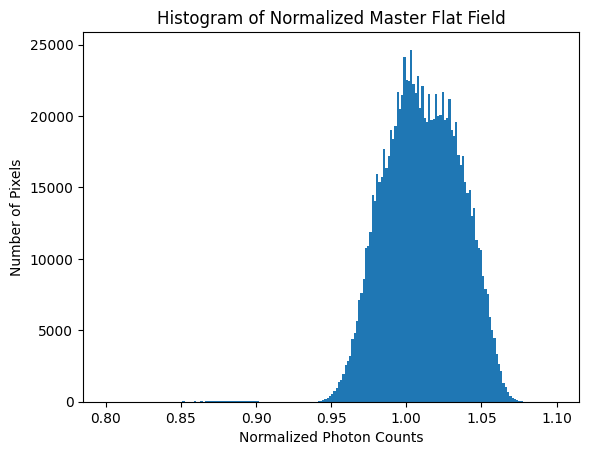

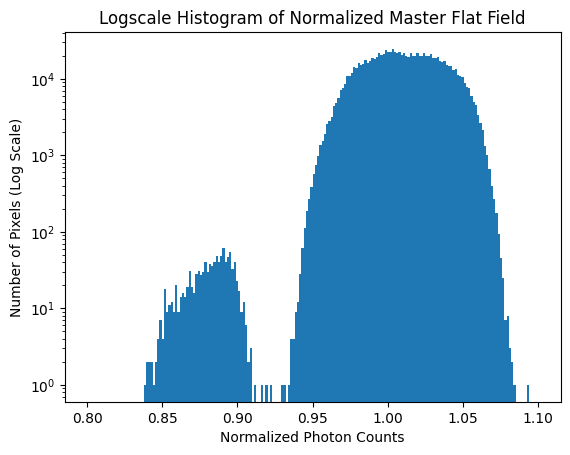

In [24]:
def plot_normalized_histograms(norm_flat, range=(0.8, 1.1), bins=200):
    """
    Plot histograms of the normalized master flat field on both linear and logarithmic scales.

    :param norm_flat: The normalized master flat field data to be plotted.
    :type norm_flat: np.ndarray
    :param linear_range: The range of normalized photon counts for the linear histogram.
    :type linear_range: tuple
    :param bins: The number of bins to use for the histograms.
    :type bins: int
    :return: None
    """
    # Plot histogram on linear scale
    plt.hist(norm_flat.flatten(), range=range, bins=bins)
    plt.xlabel('Normalized Photon Counts')
    plt.ylabel('Number of Pixels')
    plt.title('Histogram of Normalized Master Flat Field')
    plt.show()

    # Plot histogram on log scale
    plt.hist(norm_flat.flatten(), range=range, bins=bins, log=True)
    plt.xlabel('Normalized Photon Counts')
    plt.ylabel('Number of Pixels (Log Scale)')
    plt.title('Logscale Histogram of Normalized Master Flat Field')
    plt.show()

# Call the function
plot_normalized_histograms(norm_flat)

 Upon examination of the histograms, we can see that the lowest pixel value is approximately 84% of the mode value. This suggests that there are no dead pixels present in the image since dead pixels would typically register significantly lower counts, often approaching zero. The significance of this finding lies in the confirmation of a relatively uniform sensitivity across the detector. Additionally, the log-scale histogram indicates that the distribution of pixel counts is not binomial; with one region being cluttered around around 0.87 and 0.93 of the mode value, and 0.95 and 1.07 of the mode value. This clustering suggests a concentration of pixel values in these regions, indicating that while the flat field may have some variations, it remains generally consistent in terms of light sensitivity.

##### Section 4.3.5:
If flat-field images are not captured during the same time as the oberservations, it is not advisable to retake them at a later time. This is because flat-field calibration requires that the optical system remains in the same configuration and environmental conditions as during the acquisition of the light frames. Variations in factors such as atmospheric conditions, temperature, exposure times, filters, and telescope positioning can significantly affect the sensitivity and response of the detector. Therefore, to ensure accurate calibration, flat fields should ideally be obtained on the same night, under conditions as close as possible to those when the actual observations were made.

## Section 4.4: Spectroscopic calibration
This section focuses on the dispersion of the spectrograph, a device designed to separate light into its component wavelengths for spectral analysis. We explore how this dispersion influences the flat-field response, particularly in terms of sensitivity variations across different spectral regions. The calibration of spectroscopic data is essential for normalizing the flat-field response, which allows us to account for intrinsic sensitivity variations. This process is vital for ensuring accurate measurements of emission lines and their corresponding wavelengths, thereby enhancing the reliability of our spectroscopic analysis.
##### Section 4.4.1:
To effectively calibrate our spectrograph images, we utilize flat fields derived from known spectra, similar to the approach taken with data collected from the STL1001 camera. For this purpose, we selected the well-known emission spectra of neon as our test source. We begin this section by opening the spectroscopic flat-field image obtained from the DADOS spectrograph, which showcases the three distinct spectral bands corresponding to three slits with widths of 25 µm, 35 µm, and 50 µm. The resulting image facilitates a clear observation of how the different slits contribute to the overall spectral output. The methodology is as simple as employing `fit.getdata` to extract the flat-file data, subtracting the associated dark frame, and then using `imshow` to render the 2D array data as a grayscale image. 

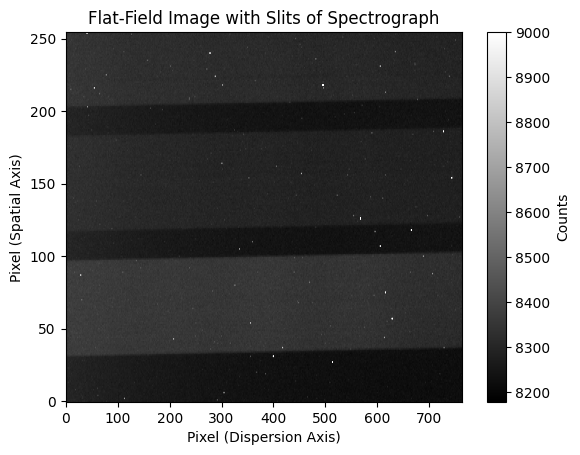

In [25]:
def display_spectroscopic_flat_field(file_path, vmax=9000):
    """
    Open the spectroscopic flat-field FITS file and display the image.

    :param file_path: The path to the FITS file containing the spectroscopic flat-field data.
    :type file_path: str
    :param vmax: The maximum value for the color scaling of the image (default is 9000).
    :type vmax: int, optional
    :return: The 2D array containing the flat-field image data.
    :rtype: np.ndarray
    """
    # Load the spectroscopic flat-field data from the specified FITS file
    flat_data = fits.getdata(file_path)
    # Plot the image to inspect the spectra
    plt.imshow(flat_data, cmap='gray', origin='lower', aspect='auto', vmax=vmax)
    plt.colorbar(label='Counts')
    plt.title('Flat-Field Image with Slits of Spectrograph')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Pixel (Spatial Axis)')
    plt.show()
    
    return flat_data

# Call the function
flat_data = display_spectroscopic_flat_field('../FITS_Files/3.4_Spectropic_Flat_Fields_10_sec.00000003.FLAT.FIT')

By examining the spectroscopic flat-field image, we determined that the bottom spectral band corresponds to the 50 µm slit. This visual inspection enabled us to identify the region of interest for cropping, specifically selecting rows 0 to 110 along the spatial axis to isolate the spectral data produced by the 50 µm slit. To achieve this, we utilized array slicing, allowing us to extract a subsection of the 2D data efficiently. Once we cropped this portion of the image, we proceeded to plot the extracted flat-field data, which allowed us to visualize the spectral response from the 50 µm slit. This focused approach ensured that we captured the essential details required for accurate calibration and analysis. 

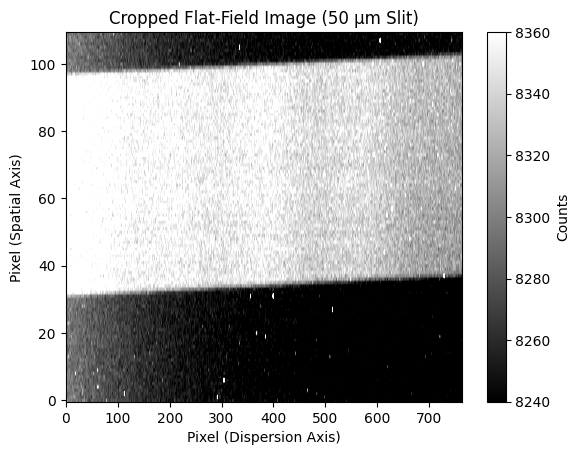

In [26]:
def plot_50um_slit(flat_data, row_start=0, row_end=110):
    """
    Crop and plot the flat-field image corresponding to the 50 µm slit.

    :param flat_data: 2D array containing the flat-field image data.
    :type flat_data: np.ndarray
    :param row_start: The starting row index for cropping (default is 0).
    :type row_start: int
    :param row_end: The ending row index for cropping (default is 110).
    :type row_end: int
    :return: Cropped flat-field data for the 50 µm slit.
    :rtype: np.ndarray
    """
    # Crop the flat-field data for the specified row range
    cropped_flat_field = flat_data[row_start:row_end, :]  # Keep all columns (dispersion axis)
    # Plot the cropped image for the 50 µm slit
    plt.imshow(cropped_flat_field, cmap='gray', origin='lower', aspect='auto', vmin=8240, vmax=8360)
    plt.colorbar(label='Counts')
    plt.title('Cropped Flat-Field Image (50 µm Slit)')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Pixel (Spatial Axis)')
    plt.show()

    return cropped_flat_field

# Call the function
cropped_flat_field = plot_50um_slit(flat_data)

##### Section 4.4.2:
By examining the cropped flat-field data for the 50 µm slit, we identified several brighter regions, which indicate areas of higher counts that are relevant for our analysis. This region spans approximately from pixel positions 35 to 95 along the spatial axis. Using this range, we extracted the corresponding rows from the 2D flat-field array, calculated the median value of each column with NumPy functions, and plotted the resulting 1D flat-field data. This approach allows us to focus on the spectral response associated with the 50 µm slit, enhancing the accuracy of our calibration and subsequent analysis.

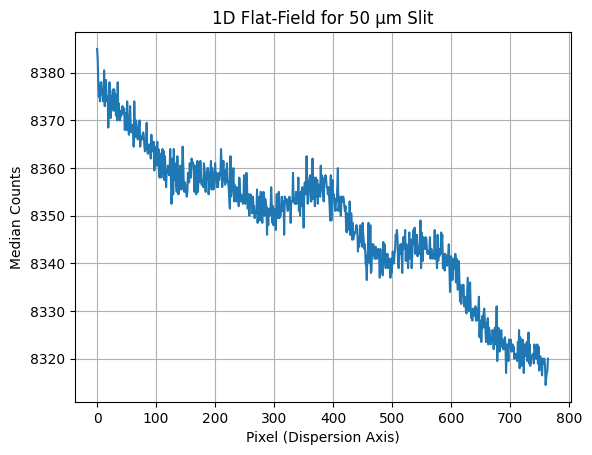

In [27]:
def collapse_flat_field_1d(flat_data, row_start=35, row_end=95):
    """
    Collapse the cropped 50 µm flat-field image data from 2D to 1D by extracting the data
    from the specified slit and taking the median value of each column.
    
    :param flat_data: 2D array containing the flat-field image data.
    :type flat_data: np.ndarray
    :param row_start: The starting row index for extracting the 50 µm slit data (default is 40).
    :type row_start: int
    :param row_end: The ending row index for extracting the 50 µm slit data (default is 80).
    :type row_end: int
    :return: 1D array of median flat-field values for the specified slit.
    :rtype: np.ndarray
    """
    # Extract the data for the 50 µm slit
    slit_flat_data = flat_data[row_start:row_end, :]
    # Collapse the 2D image to a 1D array by taking the median of each column
    flat_1d = np.median(slit_flat_data, axis=0)
    # Plot the 1D flat-field values against pixel positions
    plt.plot(flat_1d)
    plt.title('1D Flat-Field for 50 µm Slit')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Median Counts')
    plt.grid(True)
    plt.show()

    return flat_1d

# Call the function
flat_1d = collapse_flat_field_1d(flat_data)

##### Section 4.4.3:
Now we focus on normalizing the 1D flat-field data to account for variations in sensitivity along the dispersion axis. To achieve this, we first fit a low-order polynomial to the observed 1D flat-field spectrum using NumPy’s Polynomial fitting capabilities. This fitting process helps us model the underlying sensitivity variations by generating a smooth curve that represents the expected response of the spectrograph across the wavelengths of interest. We then divide the original flat-field data by this polynomial fit, effectively normalizing the data so that it varies around one. This normalization allows any remaining fluctuations in the data to be interpreted as true differences in sensitivity, while minimizing the influence of the intrinsic spectrum of the lamp used to obtain the flat-field. The normalized 1D flat-field is then plotted to visually assess the changes and ensure that the calibration process is effective in addressing the biases present in the original data.

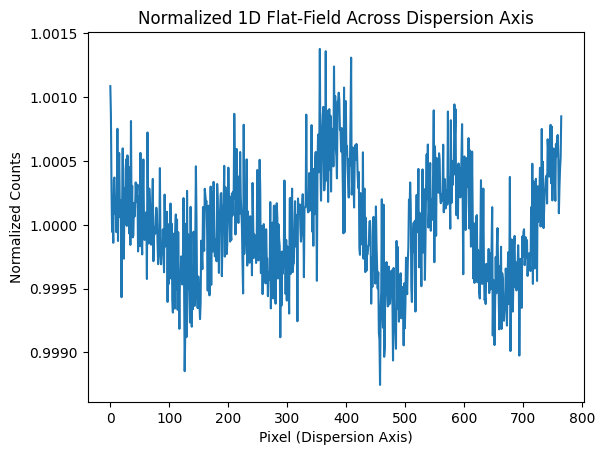

In [28]:
def normalize_flat_field(flat_1d, degree=3):
    """
    Normalize the 1D flat-field data by fitting a low-order polynomial and dividing the 
    original data by the fit.

    :param flat_1d: 1D array containing the flat-field data to be normalized.
    :type flat_1d: np.ndarray
    :param degree: Degree of the polynomial fit (default is 3).
    :type degree: int
    :return: The normalized 1D flat-field data.
    :rtype: np.ndarray
    """
    # Fit a low-order polynomial to the 1D flat-field data
    p = Polynomial.fit(np.arange(len(flat_1d)), flat_1d, deg=degree)
    # Evaluate the polynomial to get the fit values
    fit_values = p(np.arange(len(flat_1d)))
    # Normalize the 1D flat-field by dividing by the fit
    normalized_flat_1d = flat_1d / fit_values
    # Plot the normalized 1D flat-field
    plt.plot(normalized_flat_1d)
    plt.title('Normalized 1D Flat-Field Across Dispersion Axis')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Normalized Counts')
    plt.show()
    
    return normalized_flat_1d

# Call the function
normalized_flat_1d = normalize_flat_field(flat_1d)

For this part of the analysis we aimed to compare the original cropped flat-field image with the normalized flat-field spectrum. To achieve this, we divide the cropped flat-field image by the normalized 1D flat-field data obtained in the previous step. This division allows us to assess how the spectral response varies when the original raw data is adjusted for intrinsic variations in sensitivity. 

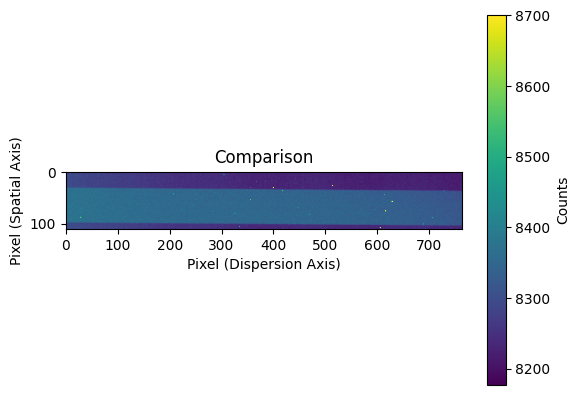

In [29]:
def compare_normalized_flat_field(cropped_flat_field, normalized_flat_1d, vmax=8700):
    """
    Compare the cropped flat-field image with the normalized flat-field spectrum by dividing the 
    cropped flat-field by the normalized flat-field data.

    :param cropped_flat_field: 2D array containing the cropped flat-field image data.
    :type cropped_flat_field: np.ndarray
    :param normalized_flat_1d: 1D array containing the normalized flat-field data.
    :type normalized_flat_1d: np.ndarray
    :param vmax: The maximum value for the color scaling of the image (default is 8700).
    :type vmax: int, optional
    :return: None; displays the comparison image.
    :rtype: None
    """
    # Compare the cropped flat-field image with the normalized flat-field
    compare = cropped_flat_field / normalized_flat_1d
    
    # Plot the comparison image
    plt.imshow(compare, vmax=vmax)
    plt.colorbar(label='Counts')
    plt.title('Comparison')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Pixel (Spatial Axis)')
    plt.show()

# Call the function
compare_normalized_flat_field(cropped_flat_field, normalized_flat_1d)

When viewing the normalized flat-field image in DS9, the count values exhibit a more consistent distribution around 1, with significantly reduced fluctuations and fewer areas of excessive brightness. This indicates that the calibration of our master flat field has been successfully achieved. Therefore, we can confidently apply this calibrated flat field to our arc lamp spectra for further analysis in the next subsection.

##### Section 4.4.4:
The function below extracts the desired section of the arc lamp spectrum corresponding to the 50 µm slit from the FITS file. This was achieved by using a function that reads in the FITS file and crops the two-dimensional arc lamp spectrum to match the region previously used for the flat-field data. Once extracted, the cropped arc lamp spectrum was visualized as a two-dimensional image. By matching the cropped arc lamp spectrum to the exact region of the flat-field, we were able to prepare this data for the subsequent flat-field correction, thereby minimizing any spatial inconsistencies that could impact the spectral analysis. 

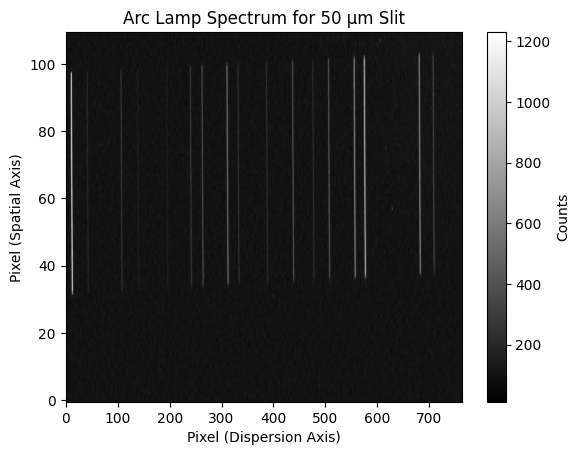

In [30]:
def extract_arc_lamp_spectrum(file_path, row_start=0, row_end=110):
    """
    Extract the arc lamp spectrum of the 50 µm slit from the provided FITS file. The cut-out 
    is performed to match the region defined for the flat-field data.

    :param file_path: Path to the FITS file containing the arc lamp data.
    :type file_path: str
    :param row_start: Starting row index for cropping (default is 0).
    :type row_start: int
    :param row_end: Ending row index for cropping (default is 110).
    :type row_end: int
    :return: The cropped 2D arc lamp spectrum for the 50 µm slit.
    :rtype: np.ndarray
    """
    # Extract the 2D arc lamp data from the first extension of the FITS file
    light_data = fits.getdata(file_path)
    # Crop the arc lamp data to match the flat-field region for the 50 µm slit
    cropped_light_field = light_data[row_start:row_end, :]
    # Plot the cropped image to inspect the spectra
    plt.imshow(cropped_light_field, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar(label='Counts')
    plt.title('Arc Lamp Spectrum for 50 µm Slit')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Pixel (Spatial Axis)')
    plt.show()

    return cropped_light_field

# Call the function
cropped_light_field = extract_arc_lamp_spectrum('../FITS_Files/3.4_Spectropic_Neon_10_sec.00000001.FIT')

We then applied the flat-field correction to the neon arc lamp spectrum. First, the cropped 2D arc lamp spectrum was collapsed into a 1D array by calculating the median intensity along the spatial axis, resulting in a single profile of the arc lamp. This median operation provided a representative 1D spectrum while reducing noise along the slit. The 1D arc spectrum was then corrected by dividing it by the previously computed normalized flat-field data, effectively removing sensitivity variations along the x-axis. After the flat-field correction, peaks in the spectrum were identified using a height threshold of 112 counts, which had been fine-tuned to capture the real peaks while filtering out noise. The corrected spectrum was then plotted, with the identified peaks highlighted for easy visual identification.

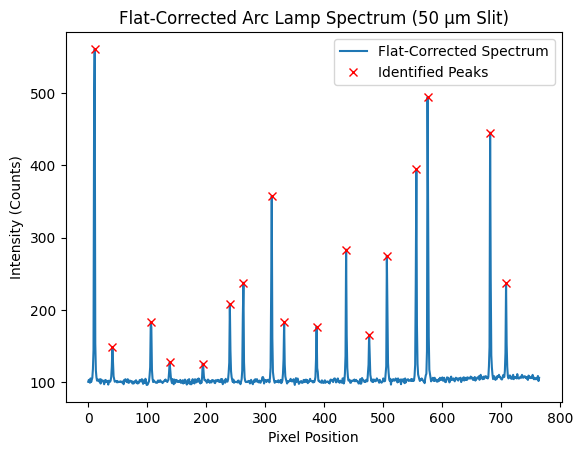

In [31]:
def apply_flat_field_correction(cropped_light_field, normalized_flat_1d, peak_threshold=112):
    """
    Apply the normalized flat-field correction to the arc lamp spectrum and identify peaks.

    :param cropped_light_field: 2D array containing the cropped arc lamp spectrum.
    :type cropped_light_field: np.ndarray
    :param normalized_flat_1d: 1D array containing the normalized flat-field data.
    :type normalized_flat_1d: np.ndarray
    :param peak_threshold: The height threshold for identifying peaks in the flat-corrected spectrum (default is 112).
    :type peak_threshold: int, optional
    :return: 1D array of the flat-corrected arc lamp spectrum and indices of identified peaks.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Collapse the cropped 2D arc lamp spectrum to 1D by taking the median along the spatial axis
    cropped_light_field_1d = np.median(cropped_light_field, axis=0)
    # Apply the normalized flat-field to the arc lamp spectrum to correct for sensitivity variations
    flat_corrected_arc = cropped_light_field_1d / normalized_flat_1d
    # Identify peaks in the flat-corrected arc lamp spectrum using the specified threshold
    peak_idxs = find_peaks(flat_corrected_arc, height=peak_threshold)
    # Plot the flat-corrected arc lamp spectrum
    plt.plot(flat_corrected_arc, label='Flat-Corrected Spectrum')
    plt.plot(peak_idxs[0], flat_corrected_arc[peak_idxs[0]], 'rx', label='Identified Peaks')
    # Customize plot appearance
    plt.title('Flat-Corrected Arc Lamp Spectrum (50 µm Slit)')
    plt.xlabel('Pixel Position')
    plt.ylabel('Intensity (Counts)')
    plt.legend()
    plt.show()

    return flat_corrected_arc, peak_idxs[0]

# Call the function
flat_corrected_arc, peak_indices = apply_flat_field_correction(cropped_light_field, normalized_flat_1d)

##### Section 4.4.5:
We start this subsection with the objective of extracting and storing the pixel intensity values for the 17 peaks observed in the neon spectrum from the flat-corrected arc lamp spectrum, specifically recorded through a 50 µm slit. The function below takes two parameters: the `flat_corrected_arc`, which is a 1D array containing the intensity values, and `peak_indices`, which denotes the positions of the identified peaks within that spectrum. To convert the x-axis from pixel units to physical units such as nanometers, it is essential to first identify the pixel positions corresponding to each peak. Upon execution, the function retrieves the intensity values for these identified peak indices using NumPy's array indexing as assurance. 

In [32]:
def print_peak_positions_with_intensities(flat_corrected_arc, peak_indices):
    """
    Retrieve the pixel positions and corresponding intensities of the identified peaks in the flat-corrected neon arc lamp spectrum.

    :param flat_corrected_arc: 1D array containing the flat-corrected arc lamp spectrum.
    :type flat_corrected_arc: np.ndarray
    :param peak_indices: 1D array containing the indices of the identified peaks.
    :type peak_indices: np.ndarray
    :return: A tuple of the peak pixel indices and corresponding intensities.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Extract the peak intensities at the identified peak indices
    peak_intensities = flat_corrected_arc[peak_indices]

    return peak_indices, peak_intensities

# Call the function
peak_indices, peak_intensities = print_peak_positions_with_intensities(flat_corrected_arc, peak_indices)

We then focus on fitting the identified peak indices from the neon spectrum to their corresponding known wavelengths, which are provided in nanometers by the NIST Atomic Spectra Database and Kurucz CD-ROM No. 23 (https://www.atomtrace.com/elements-database/element/10). Upon constructing a list of peak indicies and known wavelengths as input, it uses a linear regression model provided by `LinearLSQFitter` in the `astropy.modeling` library. After performing the fitting, the function outputs a table and graph that presents the pixel positions alongside their associated wavelengths, facilitating a clear understanding of the relationship. 

Pixel Position | Wavelength (nm)
------------------------------
             11 |          585.24
             41 |          588.34
            106 |          594.54
            138 |          597.64
            194 |          607.38
            240 |          609.60
            263 |          614.26
            311 |          616.46
            332 |          621.56
            387 |          626.66
            437 |          630.42
            476 |          633.52
            506 |          638.16
            556 |          640.18
            575 |          650.58
            681 |          653.24
            708 |          660.00


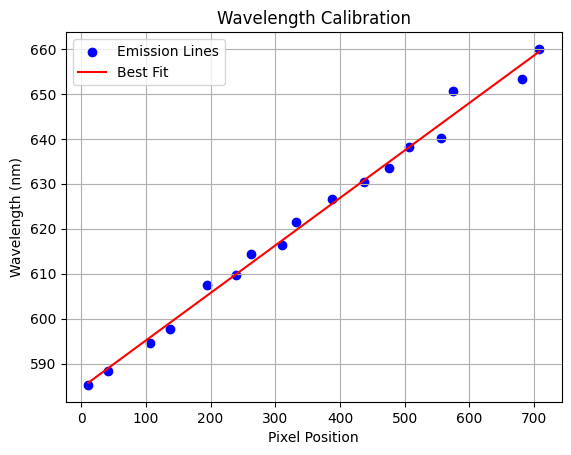

Slope: 0.1057 nm, Y-Intercept: 584.5724 nm


In [33]:
def fit_wavelengths_to_peaks(peak_indices):
    """
    Fit the identified peak indices to known wavelengths, outputs table of pixels positions and their wavelengths, 
    and generates a calibration graph, returning its slope and y-intercept. 
    
    :param peak_indices: 1D array containing the indices of the identified peaks in the spectrum.
    :type peak_indices: np.ndarray
    :return: A tuple containing the slope and y-intercept of the linear fit in nanometers.
    :rtype: tuple(float, float)
    """
    # Known Neon spectrum wavelengths in nanometers provided by known database: https://www.atomtrace.com/elements-database/element/10
    known_wavelengths = [585.24, 588.34, 594.54, 597.64, 607.38, 609.6, 614.26, 616.46, 621.56, 626.66, 630.42, 633.52, 638.16, 640.18, 650.58, 653.24, 660.0]
    # Ensure the number of peaks matches the number of known wavelengths
    if len(peak_indices) != len(known_wavelengths):
        raise ValueError("Number of identified peaks does not match the number of known wavelengths.")
    # Fit a linear model to the data
    linear_model = models.Linear1D()
    fitter = fitting.LinearLSQFitter()
    # Perform the fitting
    best_fit = fitter(linear_model, peak_indices, known_wavelengths)
    # Generate the table of pixel positions and wavelengths
    print("Pixel Position | Wavelength (nm)")
    print("-" * 30)
    for pixel_position, wavelength in zip(peak_indices, known_wavelengths):
        print(f"{pixel_position:15d} | {wavelength:15.2f}")
    # Plot the data and the best-fit line
    plt.scatter(peak_indices, known_wavelengths, color='blue', label='Emission Lines')
    plt.plot(peak_indices, best_fit(peak_indices), color='red', label='Best Fit')
    plt.xlabel('Pixel Position')
    plt.ylabel('Wavelength (nm)')
    plt.title('Wavelength Calibration')
    plt.grid(True)
    plt.legend()
    plt.show()
    # Output the slope and y-intercept of the fitted line
    slope = best_fit.slope.value
    y_intercept = best_fit.intercept.value
    print(f"Slope: {slope:.4f} nm, Y-Intercept: {y_intercept:.4f} nm")
    
    return slope, y_intercept

# Call the function
slope, y_intercept = fit_wavelengths_to_peaks(peak_indices)

The graph above illustrates a linear relationship between pixel positions and their corresponding wavelengths along the x-axis, with a slight scattering of data points. This scatter suggests that although the distance between pixel positions is not constant, the variation is not significant enough to disrupt the overall linearity of the relationship. As a result, we can establish a reliable conversion factor that translates pixel positions into physical units of nanometers. We can then apply the parameters derived from our fit—specifically, a y-intercept of 584.6 nm and a slope of 0.106 nm—to our identified spectra.

##### Section 4.4.6:
We now design a function that converts the x-axis of the flat-corrected arc lamp spectrum from pixel counts to physical units of nanometers. We apply a linear conversion formula defined in the previous subsection that effectively maps the pixel indices to physical units. Subsequently, the function generates a plot of the flat-corrected arc spectrum, displaying the intensity values against the converted wavelength values. It also identifies and marks the peaks in the spectrum as like before in previous sections. 

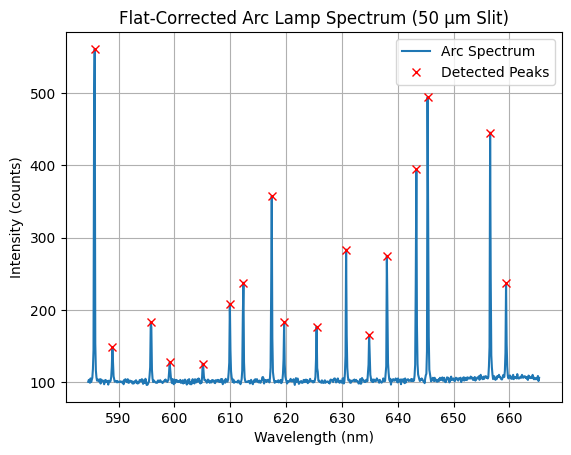

In [34]:
def convert_dispersion_to_nanometers(flat_corrected_arc, slope, y_intercept):
    """
    Convert the x-axis of the flat-corrected arc spectrum from counts to nanometers, and plot the spectrum with detected peaks.

    :param flat_corrected_arc: 1D array containing the flat-corrected arc lamp spectrum (in terms of intensity/counts).
    :type flat_corrected_arc: np.ndarray
    :param slope: The slope of the linear fit for the conversion to nanometers.
    :type slope: float
    :param intercept: The y-intercept of the linear fit for the conversion to nanometers.
    :type intercept: float
    """
    # Convert pixel positions to wavelengths (nanometers)
    wavelengths = slope * np.arange(len(flat_corrected_arc)) + y_intercept
    # Plot the flat-corrected arc spectrum
    plt.plot(wavelengths, flat_corrected_arc, label='Arc Spectrum')
    # Find peaks in the flat-corrected arc spectrum
    peaks, _ = find_peaks(flat_corrected_arc, height=112)  # Adjust the 'height' parameter as necessary
    # Mark the peaks with an 'x' symbol
    plt.plot(wavelengths[peaks], flat_corrected_arc[peaks], 'x', color='red', label="Detected Peaks")
    # Set plot titles and labels
    plt.title('Flat-Corrected Arc Lamp Spectrum (50 µm Slit)')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (counts)')
    plt.legend()
    plt.grid()
    plt.show()

# Call this function
convert_dispersion_to_nanometers(flat_corrected_arc, slope, y_intercept)

Comparing the wavelengths of the detected peaks to the databases we used before (NIST Atomic Spectra Database and Kurucz CD-ROM No. 23), we have successfully calibrated the pixel positions of our spectrograph to physical units. 

##### Section 4.4.7:
The function below determines the minimum and maximum wavelengths from the calcualted wavelength array based on our linear fit model, thereby establishing the overall wavelength range in nanometers. This range is then converted into Angstroms by multiplying the result by 10, since 1 nanometer equals 10 Angstroms. The dispersion, defined as the range of wavelengths divided by the number of pixels in the flat-corrected arc spectrum, is computed to provide a measure of wavelength resolution per pixel. The results are prineted for immediate reference.

In [35]:
def compute_wavelength_range_and_dispersion(flat_corrected_arc, slope, y_intercept):
    """
    Compute the range of wavelengths in nanometers and the dispersion of the spectrograph in Angstroms per pixel.

    :param flat_corrected_arc: 1D array containing the flat-corrected arc lamp spectrum.
    :type flat_corrected_arc: np.ndarray
    :param slope: The slope from the wavelength calibration.
    :type slope: float
    :param y_intercept: The y-intercept from the wavelength calibration.
    :type y_intercept: float
    :return: A tuple containing the range of wavelengths in nanometers and the dispersion in Angstroms per pixel.
    :rtype: tuple(float, float)
    """
    # Calculate the wavelengths based on the slope and y-intercept
    wavelengths = slope * np.arange(len(flat_corrected_arc)) + y_intercept
    # Compute the range of wavelengths
    min_wavelength = np.min(wavelengths)
    max_wavelength = np.max(wavelengths)
    range_nm = max_wavelength - min_wavelength
    # Convert range to Angstroms
    range_angstrom = range_nm * 10
    # Calculate dispersion in Angstroms per pixel
    dispersion = range_angstrom / len(flat_corrected_arc)
    # Print the results
    print(f"The wavelength ranges approximately from {min_wavelength:.5f} nm to {max_wavelength:.5f} nm, "
          f"which is approximately {range_nm:.5f} nm, or {range_angstrom:.5f} Angstroms.")
    print(f"The dispersion of the spectrograph is around {dispersion:.5f} Angstroms per pixel.")

    return range_nm, dispersion

# Call the function
wavelength_range, dispersion_value = compute_wavelength_range_and_dispersion(flat_corrected_arc, slope, y_intercept)

The wavelength ranges approximately from 584.57239 nm to 665.31002 nm, which is approximately 80.73763 nm, or 807.37634 Angstroms.
The dispersion of the spectrograph is around 1.05539 Angstroms per pixel.


From the results we see that the spectrograph has a range of 80.74 nm or 807.4 Angstorms. In addition, the DADOS spectrograph has a dispersion of approximately 1.06 Angstorms/pixel.

## Section 4.5: Calibration strategies
Calibrating astronomical data from CCD imaging and spectroscopic observations requires the effective use of various calibration files to minimize systematic errors and enhance the quality of the final data. This section will be divided into two subsections: the first focusing on CCD imaging and the second on spectrographs.

##### CCD Imagiing Calibration:
In CCD imaging, the primary calibration files include bias frames, dark frames, and flat-field images. **Bias frames** should be collected with the same instrument setup and environmental conditions as the light frames, as they capture the electronic noise inherent to the CCD camera under identical operating conditions. These frames are typically taken with the lens cap on, ensuring a zero exposure time and the same CCD temperature as the light frames. **Dark frames** are bias frames but with a nonzero exposure time. These frames account for the thermal noise generated by the CCD sensor over a specified exposure time. To ensure consistency, dark frames should ideally be taken at the same temperature and exposure time as the light frames. But since the shutter is closed, you can take it at another date. **Flat-field images** which correct for pixel-to-pixel variations and vignetting in the optical system, should be taken on the same day as the observations. This ensures that the observing conditions, including light source and position, remain consistent. Flat-fielding requires a sequence of exposures of a uniformly illuminated source, such as a twilight sky or dome flat, to create a master flat that can be applied to all corresponding light frames.

##### Spectroscopic Calibration:
For spectroscopic observations, calibration involves similar processes but includes a greater emphasis on the arc lamp spectrum for wavelength calibration. The **arc lamp spectrum** serves as the necessary reference for identifying spectral lines and should ideally be obtained using the same instrumental configuration as the target observations.In terms of data processing, it is essential to subtract the bias and dark frames from the science images to eliminate electronic noise and thermal contributions. After these corrections, flat-fielding is applied to normalize pixel variations by dividing the science frames by the master flat. For spectroscopic data, the wavelength calibration is computed using the positions of known spectral lines from the arc lamp spectrum, allowing for precise mapping of pixel values to physical wavelengths. By meticulously applying these calibration techniques, the resulting images and spectra can be accurately represented. This structured approach facilitates reliable scientific analysis, ensuring that the final outputs are as pristine and scientifically useful as possible.

## Section 4.6: Make a pretty image
The purpose of this section is to synthesize all the knowledge acquired from the previous sections of the lab and apply it to the practice of astrophotography, ensuring proper calibration and data reduction. We chose to focus on Messier 57 (M57), also known as the Ring Nebula, because it resides in the same constellation as the spectrophotometric standard star Vega, making it easier to locate through star hopping. For this section of the lad, we aim to capture a high-quality RGB image of M57, while implementing the calibration techniques developed in prior sections.

We start this section by reading a series of FITS images for M57 captured in different photometric bands: red, blue, and visible (the latter serving as our green bandpass). Each bandpass was obtained with a total exposure time of 20 seconds, consisting of two sets of 10 seconds, while maintaining the CCD temperature at $0^\circ \text{C}$. The images were then aligned using the  `astroalign` library, ensuring that the pixel positions between the images were correctly matched. The position of the red band images was used as the references to align the other two bands. After aligning, we calculated the median pretty images for the three RGB pairs of FITS files. The RGB image is constructed by stacking the aligned blue, green (visible), and red median images along a new axis, creating a 3D NumPy array with dimensions of (height, width, 3), where the third dimension corresponds to the three color channels. The alignment process guarantees that the blue and visible images correlate accurately with the red image, resulting in a cohesive representation of the astronomical object.

In [36]:
def read_and_align_pretty_images(red_template, blue_template, visible_template, start_index, end_index):
    """
    Read the pretty images (red, blue, visible) of the specified astronomical object,
    align the blue and visible images to the red image for each frame, and then
    calculate the median images for each band.
    
    :param red_template: Template path for the red images with placeholders for the frame number.
    :type red_template: str
    :param blue_template: Template path for the blue images with placeholders for the frame number.
    :type blue_template: str
    :param visible_template: Template path for the visible images with placeholders for the frame number.
    :type visible_template: str
    :param start_index: The starting index for the image frames.
    :type start_index: int
    :param end_index: The ending index for the image frames.
    :type end_index: int
    :return: A tuple containing the aligned images for each band and the median images.
    :rtype: tuple (list of tuples, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray)
    """
    # Load and align images for each color band
    red_images, blue_images, visible_images = [], [], []
    for i in range(start_index, end_index + 1):
        # Construct file paths
        red_file = red_template.format(i)
        blue_file = blue_template.format(i)
        visible_file = visible_template.format(i)
        # Read FITS files
        with fits.open(red_file) as red_hdul, fits.open(blue_file) as blue_hdul, fits.open(visible_file) as visible_hdul:
            red_data = red_hdul[0].data
            blue_data = blue_hdul[0].data
            visible_data = visible_hdul[0].data
            # Use red frame as reference for alignment
            aligned_blue, _ = aa.register(blue_data, red_data)
            aligned_visible, _ = aa.register(visible_data, red_data)
            # Store aligned images
            red_images.append(red_data)
            blue_images.append(aligned_blue)
            visible_images.append(aligned_visible)
    # Convert lists to numpy arrays for median calculation
    red_images = np.array(red_images)
    blue_images = np.array(blue_images)
    visible_images = np.array(visible_images)
    # Calculate median images for each band
    median_red = np.median(red_images, axis=0)
    median_blue = np.median(blue_images, axis=0)
    median_visible = np.median(visible_images, axis=0)
    # Return the aligned images and median images
    return (red_images, blue_images, visible_images), median_red, median_blue, median_visible

# Template for the file names
red_file_template = r"..\FITS_Files\ring_nebula_for_10_sec_red.{:08d}.FIT" 
blue_file_template = r"..\FITS_Files\ring_nebula_for_10_sec_blue.{:08d}.FIT"
visible_file_template = r"..\FITS_Files\ring_nebula_for_10_sec_visible.{:08d}.FIT"

# Define the starting and ending indices
pretty_start_index = 0 
pretty_end_index = 2  

# Call the function
pretty_images, median_red, median_blue, median_visible = read_and_align_pretty_images(
    red_file_template, blue_file_template, visible_file_template, pretty_start_index, pretty_end_index
)

Next, we read the dark frames corresponding to the RGB images and compute their median dark frame. The methodology for reading these dark frames and calculating the median is identical to that used for the pretty images.

In [37]:
def read_dark_frames(file_template, start_index, end_index):
    """
    Read dark frames from FITS files and calculate their median dark frame.

    :param file_template: Template path for the dark files with placeholders for the frame number.
    :type file_template: str
    :param start_index: The starting index for the dark frames.
    :type start_index: int
    :param end_index: The ending index for the dark frames.
    :type end_index: int
    :return: A tuple containing a list of headers and data of the loaded dark frames,
             and the median dark frame.
    :rtype: tuple (list of tuples, np.ndarray)
    """
    # List to store the FITS data and headers
    dark_frame_info = []
    # Loop through each dark frame and read the data
    for i in range(start_index, end_index + 1):
        # Construct the file name based on the frame number
        file_path = file_template.format(i)
        # Open the FITS file and read the header and data
        with fits.open(file_path) as hdul:
            header = hdul[0].header
            data = hdul[0].data
            # Store the header and data
            dark_frame_info.append((header, data))
    # Calculate the median dark frame
    dark_frames_data = np.array([frame[1] for frame in dark_frame_info])
    median_dark_frame = np.median(dark_frames_data, axis=0)

    return dark_frame_info, median_dark_frame

# Template for the dark frame file names
dark_frame_file_template = r"..\FITS_Files\ring_nebula_dark_frame_10_sec.{:08d}.DARK.FIT" 

# Define the starting and ending indices
dark_start_index = 4
dark_end_index = 6 

# Call the function
dark_frames_info, median_dark_frame = read_dark_frames(dark_frame_file_template, dark_start_index, dark_end_index)

In this section, we read in the flat fields, compute their median, subtract the median dark frame to correct for thermal effects, and normalize the result by dividing by the mode of the corrected median flat field. The methodology of reading the FITS files is the same as with the pretty images and the dark frames. Unfortunately, our group forgot obtain our own flat fields, so we had to use data borrowed from Group 3. Their flat fields were taken at an exposure time of 9 seconds with the CCD temperature maintained at $0^\circ \text{C}$, closely mimicking our conditions of 10 seconds and the same temperature. For consistency, we used three of their flat fields, similar to the three FITS files we used for each band in our RGB image. However, it is important to note that Group 3 captured their flat fields only in the visible bandpass, rather than across red, blue, and visible bands. This is significant, as flat fields taken in a specific bandpass provide calibration for the sensitivity and vignetting effects present in that particular band. Since our borrowed data is all in the visible band and was taken on a different date than our observations, this compromises the accuracy of noise reduction across the red and blue channels of our RGB image. While not ideal, using these flat fields is the best available option given the circumstances.

In [38]:
def read_and_process_flat_fields(file_template, start_index, end_index, median_dark_frame):
    """
    Read flat field frames from FITS files, calculate the median flat field, subtract the median dark frame,
    and normalize by dividing by the mode.

    :param file_template: Template path for the flat field files with placeholders for the frame number.
    :type file_template: str
    :param start_index: The starting index for the flat field frames.
    :type start_index: int
    :param end_index: The ending index for the flat field frames.
    :type end_index: int
    :param median_dark_frame: The median dark frame to be subtracted from the flat field frames.
    :type median_dark_frame: np.ndarray
    :return: A tuple containing a list of headers and data of the loaded flat field frames,
             and the normalized median flat field.
    :rtype: tuple (list of tuples, np.ndarray)
    """
    # List to store the FITS data and headers
    flat_frame_info = []
    # Loop through each flat field frame and read the data
    for i in range(start_index, end_index + 1):
        # Construct the file name based on the frame number
        file_path = file_template.format(i)
        # Open the FITS file and read the header and data
        with fits.open(file_path) as hdul:
            header = hdul[0].header
            data = hdul[0].data
            # Store the header and data
            flat_frame_info.append((header, data))
    # Calculate the median flat field frame
    flat_frames_data = np.array([frame[1] for frame in flat_frame_info])
    median_flat_frame = np.median(flat_frames_data, axis=0)
    # Subtract the median dark frame
    corrected_flat_frame = median_flat_frame - median_dark_frame
    # Calculate the mode of the corrected flat frame
    mode_value = stats.mode(corrected_flat_frame, axis=None, keepdims=False)[0]
    # Normalize by dividing by the mode
    normalized_flat_frame = corrected_flat_frame / mode_value

    return flat_frame_info, normalized_flat_frame

# Template for the flat field file names
flat_field_file_template = r"..\FITS_Files\flat_0C_.{:08d}.FIT"

# Define the starting and ending indices
flat_start_index = 0
flat_end_index = 2

# Call the function
flat_frames_info, normalized_median_flat_frame = read_and_process_flat_fields(
    flat_field_file_template, flat_start_index, flat_end_index, median_dark_frame
)

We perform the calibration of median images for the three color bands (red, blue, and visible) by correcting for instrumental effects such as dark current and non-uniform pixel sensitivity. The function described below takes as input the median red, blue, and visible images (which have already been aligned), along with a median dark frame and a normalized median flat field. The calibration process consists of two main steps for each color band: dark subtraction and flat-field correction. First, the median dark frame is subtracted from each median image to remove the effects of thermal noise and read noise, ensuring that only the photon signal remains. In the second step, the dark-subtracted images are divided by the normalized median flat field, correcting for pixel sensitivity variations and vignetting effects across the detector. This calibration results in fully corrected red, blue, and visible images, which are then returned as a tuple.

In [39]:
def calibrate_pretty_images(median_red, median_blue, median_visible, median_dark_frame, normalized_median_flat_frame):
    """
    Calibrate median pretty images (red, blue, and visible) by subtracting the median dark frame 
    and dividing by the normalized median flat field.

    :param median_red: The median red image as a 2D NumPy array.
    :type median_red: np.ndarray
    :param median_blue: The median blue image as a 2D NumPy array.
    :type median_blue: np.ndarray
    :param median_visible: The median visible image as a 2D NumPy array.
    :type median_visible: np.ndarray
    :param median_dark_frame: The median dark frame as a 2D NumPy array.
    :type median_dark_frame: np.ndarray
    :param normalized_median_flat_frame: The normalized median flat field as a 2D NumPy array.
    :type normalized_median_flat_frame: np.ndarray
    :return: A tuple containing the calibrated red, blue, and visible images.
    :rtype: tuple (np.ndarray, np.ndarray, np.ndarray)
    """
    # Subtract the median dark frame from each of the median pretty images
    corrected_red_image = median_red - median_dark_frame
    corrected_blue_image = median_blue - median_dark_frame
    corrected_visible_image = median_visible - median_dark_frame
    # Divide each corrected image by the normalized median flat field to calibrate
    calibrated_red_image = corrected_red_image / normalized_median_flat_frame
    calibrated_blue_image = corrected_blue_image / normalized_median_flat_frame
    calibrated_visible_image = corrected_visible_image / normalized_median_flat_frame

    return calibrated_red_image, calibrated_blue_image, calibrated_visible_image

# Call the function
calibrated_red, calibrated_blue, calibrated_visible = calibrate_pretty_images(
    median_red, median_blue, median_visible, median_dark_frame, normalized_median_flat_frame
)

To ensure proper alignment of each color band, we again use the `astroalign` library to stack the fully calibrated median images. This process involved aligning the blue and red images to the visible image, resulting in a set of aligned images for each filter. These aligned images were saved to the working directory for further processing. Next, each of the three aligned images was run through `astrometry.net` to assign Right Ascension (RA) and Declination (DEC) coordinates to each pixel, providing additional assurance of alignment accuracy and ensuring that the images were well-registered to the celestial sphere. After verifying the alignment, we used SAOImage DS9 to create a composite image. By loading the aligned images into the red, blue, and green (visible) channels, we produced an RGB image. To enhance visual quality, the Gaussian smoothing function was applied, which helps to reduce noise and bring out subtle details, resulting in a polished final image suitable for presentation.

In [40]:
def align_calibrated_images(calibrated_red, calibrated_blue, calibrated_visible):
    """
    Align the calibrated red and blue images to the calibrated visible image using astroalign.

    :param calibrated_red: The fully calibrated median red image as a 2D NumPy array.
    :type calibrated_red: np.ndarray
    :param calibrated_blue: The fully calibrated median blue image as a 2D NumPy array.
    :type calibrated_blue: np.ndarray
    :param calibrated_visible: The fully calibrated median visible image as a 2D NumPy array.
    :type calibrated_visible: np.ndarray
    :return: A tuple containing the aligned red, blue, and visible images.
    :rtype: tuple (np.ndarray, np.ndarray, np.ndarray)
    """
    # Align the blue and red images to the visible image
    aligned_blue, _ = aa.register(calibrated_visible, calibrated_blue)
    aligned_red, _ = aa.register(calibrated_visible, calibrated_red)

    # Save the aligned images as FITS files
    fits.PrimaryHDU(aligned_blue).writeto("aligned_blue.fits", overwrite=True)
    fits.PrimaryHDU(aligned_red).writeto("aligned_red.fits", overwrite=True)
    fits.PrimaryHDU(calibrated_visible).writeto("aligned_visible.fits", overwrite=True)

    return aligned_red, aligned_blue, calibrated_visible

# Example usage
aligned_red, aligned_blue, aligned_visible = align_calibrated_images(
    calibrated_red, calibrated_blue, calibrated_visible
)

The image of M57 presented below showcases the results after completing all the calibration steps. However, some imperfections emerged during the process. While the alignment using `astroalign` was generally effective, slight misalignments persisted in certain areas, particularly around high-contrast edges. This observation prompted us to run the calibrated images through `astrometry.net` to further ensure the alignment and eliminate these artifacts. Additionally, the flat fields used in the calibration were not fully representative of the data, as we did not acquire them appropriately. This discrepancy resulted in uneven brightness and color representation in areas affected by significant vignetting.

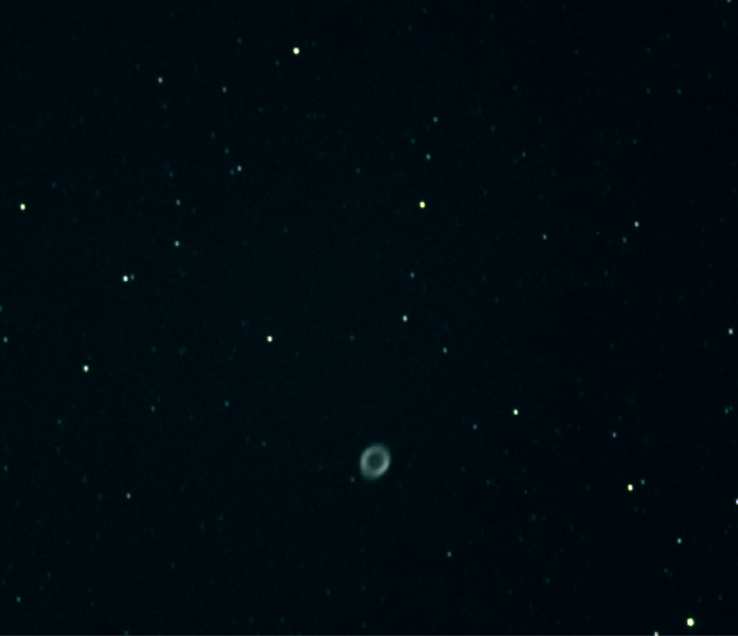

In [41]:
def display_pretty_image(image_path):
    """
    Display the pretty image specified by the given file path.

    :param image_path: The path to the pretty image file to be displayed.
    :type image_path: str
    """
    # Display the pretty image
    display(Image(image_path))

# Call the function with the specified image path
display_pretty_image(r"..\Misha_Work\pretty_picture.png")

From these experiences, several valuable lessons were learned that can improve future calibration efforts. First, implementing a more rigorous color calibration process, potentially involving spectrophotometric standards, would enhance the accuracy of color representation in the final composite images. Moreover, refining the dark frame calibration by acquiring dark frames at multiple temperatures or exposure times could better characterize dark current variations, leading to more accurate corrections, much like the approach we employed in Section 4.2. These adjustments will be crucial in achieving higher-quality images and more reliable calibration in future projects. 

## Conclusions:
This lab served as an important introduction on not only proper procedure on how to use the telescope atop of Mt. Stony Brook, but also essential calibration tehcniques required to obtain good data for astronomical imaging and spectroscopic observations. In Section 4.1, we took taking a bias frame at the temperature of our observations ($0^\circ \text{C}$), we were able to see that there were 413 hot pixels (or about 0.04% of all pixels). After calculating the mean and standard deviation of the pixel values in the bias frame, we determined a read noise value of approximately 15.44 $e^{-}$, which is consistent with the manual's statement of 14.8 $e^{-}$. In Section 4.2, we focused on the acquisition and analysis of dark frames that range from exposure times from 10 to 120 seconds to create a master dark frame. The analysis of the dark frames revealed the presence of 10 hot pixels consistently across all exposures and 23 warm pixels appearing in every frame. Notably, we identified 3 warm pixels that were exclusively present in the master dark frame. Additionally, by plotting exposure time against mean pixel counts, we derived a dark current rate of 0.751 ± 0.001 e-/p/s at for frames observed with temeprature $0^\circ \text{C}$ and 3.237 ± 0.014 e-/p/s for frames observed with temperature $10^\circ \text{C}$.

In Section 4.3, we focused on the analysis of flat fields to assess the uniformity of our imaging system and identify potential pixel anomalies. We took the median of our 10 flat-fields and then divide it by the mode to normalize it. By examining a histogram of the master flat field data, we concluded that there were no dead pixels present in the imaging array, which is crucial for ensuring the accuracy and reliability of subsequent observations. Additionally, we emphasized the necessity of capturing flat field images on the same day as the scientific observations. In Section 4.4, we conducted a thorough calibration of the DADOS spectrograph, focusing on determining its wavelength range and dispersion characteristics using a neon arc lamp. Through the analysis of the arc lamp spectrum, we established that the spectrograph operates over a wavelength range of 807.4 Angstroms. Additionally, we calculated the dispersion of the spectrograph, finding it to be approximately 1.06 Angstroms per pixel. And finally in Section 4.6, we focused on the astrophotography of M57, putting all together the calibration strategies laid out throughout the data analysis. 

In conclusion, this lab reinforced the theoretical principles of data calibration while providing practical insights into the complexities encountered in astronomical research. The methodolgies of generating master dark and flat-fields will serve to be crucial for the remaining astronomical observations this semester. 